In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, mode
import numpy as np

In [70]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

sns.set_theme(style='white', font_scale=1.2)
TIP_colors =  ["#1B4355", "#CB7A2C", "#7A8F50"]
sns.set_palette(TIP_colors)

# HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [71]:
sns.color_palette(TIP_colors)

[(0.10588235294117647, 0.2627450980392157, 0.3333333333333333),
 (0.796078431372549, 0.47843137254901963, 0.17254901960784313),
 (0.47843137254901963, 0.5607843137254902, 0.3137254901960784)]

In [72]:
df = pd.read_csv('TIP_StudentData.csv', parse_dates=['DOB', 'GraduatedDate', 'InterviewedDate','StartDate','EndDate'])

In [73]:
df_race = pd.read_csv('tip_cohort_demographics_rg.csv')[['tip_id', 'census_tract', 'gender', 'race']]
df_earnings = pd.read_csv('tip_cohort_uiearnings.csv')

C:\Users\13429\AppData\Local\Temp\ipykernel_1204\643001246.py:2: DtypeWarning: Columns (3,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_earnings = pd.read_csv('tip_cohort_uiearnings.csv')


In [74]:
def status(row):
    if not pd.isnull(row['GraduatedDate']):
        return 'Graduated'
    elif (not pd.isnull(row['StartDate'])) & (not pd.isnull(row['EndDate'])) & ((row['EndDate'] - row['StartDate']).days < 78):
        return 'Non Graduated'
    elif (not pd.isnull(row['InterviewedDate'])) & ((pd.isnull(row['EndDate'])) or (row['EndDate'] - row['InterviewedDate']).days < 78):
        return 'Interviewed'
    else:
        return 'None'
    
df['Status'] = df.apply(status, axis=1)

In [75]:
df['Status'].value_counts()

Status
Graduated        759
Non Graduated    703
Interviewed      550
None             295
Name: count, dtype: int64

In [76]:
df_not_none = df[df['Status'] != 'None'].copy()

In [77]:
df = pd.merge(
    df_not_none,
    df_race,
    on='tip_id',
    how='left'
)

In [78]:
len(df)

2012

In [79]:
df.head()

,tip_id,DOB,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,Status,census_tract,gender,race
0,1,1992-08-26,NaT,NaT,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,Non Graduated,4.200356e+10,Male,Black
1,4,1982-08-15,2013-10-16,NaT,2013-08-12,2013-10-16,NaN,Introduction to Masonry,2018-07-12,Graduated,4.200313e+10,Male,Black
2,5,1988-04-10,2011-02-04,NaT,2010-11-29,2011-02-04,NaN,Introduction to Masonry,2018-07-12,Graduated,NaN,NaN,NaN
3,6,1985-04-16,NaT,NaT,2013-07-24,2013-09-06,NaN,Introduction to Masonry,2018-07-12,Non Graduated,4.212981e+10,Male,Black
4,7,1990-01-26,NaT,NaT,2013-08-19,2013-08-27,NaN,Introduction to Masonry,2018-07-12,Non Graduated,4.211102e+10,Male,Black


In [80]:
df['Status'].value_counts()

Status
Graduated        759
Non Graduated    703
Interviewed      550
Name: count, dtype: int64

In [81]:
df['race'].value_counts(dropna=False) / len(df) * 100

race
Black    85.288270
White     8.697813
NaN       5.765408
Other     0.248509
Name: count, dtype: float64

In [82]:
df_grad = df[df['Status'] == 'Graduated']
df_non_grad = df[df['Status'] == 'Non Graduated']

cols_to_check = ['gender', 'race']

for name, target_df in [("Graduated", df_grad), ("Non Graduated", df_non_grad)]:
    print(f"\n" + "="*30)
    print(f"{name}: ")
    print("="*30)
    
    for col in cols_to_check:
        print(f"\n--- {col} ---")
        counts = target_df[col].value_counts(dropna=False)
        percent = target_df[col].value_counts(dropna=False, normalize=True) * 100
        
        dist_df = pd.DataFrame({'Count': counts, 'Percentage (%)': percent.round(2)})
        print(dist_df)


Graduated: 

--- gender ---
        Count  Percentage (%)
gender                       
Male      661           87.09
Female     72            9.49
NaN        26            3.43

--- race ---
       Count  Percentage (%)
race                        
Black    651           85.77
White     73            9.62
NaN       33            4.35
Other      2            0.26

Non Graduated: 

--- gender ---
        Count  Percentage (%)
gender                       
Male      607           86.34
Female     61            8.68
NaN        35            4.98

--- race ---
       Count  Percentage (%)
race                        
Black    614           87.34
White     50            7.11
NaN       37            5.26
Other      2            0.28


In [83]:
curr_df = df[(df['Status'] == 'Graduated') | (df['Status'] == 'Non Graduated')]
# curr_df['race'].value_counts(dropna=False) / len(curr_df) * 100

In [84]:
# df['gender'].value_counts(dropna=False) / len(df) * 100

In [85]:
# curr_df['gender'].value_counts(dropna=False) / len(curr_df) * 100

In [86]:
df_earnings['year'] = df_earnings['quarter'].astype(str).str[:4]
df_earnings['quarter_df'] = df_earnings['quarter'].astype(str).str[4:]
df_earnings['year_quarter'] = df_earnings['year'] + 'Q' + df_earnings['quarter_df']
df_earnings['year_quarter_dt'] = pd.PeriodIndex(df_earnings['year_quarter'], freq='Q').to_timestamp()
df_earnings['year_month'] = df_earnings['year_quarter_dt'].dt.to_period('M')

In [87]:
df_earnings.drop(columns=['Unnamed: 0'], inplace=True)

In [88]:
df_earnings

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,naics_industry_2022,year,quarter_df,year_quarter,year_quarter_dt,year_month
0,655,20182,LEHIGH VALLEY RESTAURANT GROUP INC,1434,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,Full-Service Restaurants,2018,2,2018Q2,2018-04-01,2018-04
1,556,20174,COST COMPANY,3147,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,4,2017Q4,2017-10-01,2017-10
2,556,20174,FRANCO,4654,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,4,2017Q4,2017-10-01,2017-10
3,556,20181,COST COMPANY,1908,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,1,2018Q1,2018-01-01,2018-01
4,556,20181,FRANCO,7165,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,1,2018Q1,2018-01-01,2018-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73271,1052,20172,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,2,2017Q2,2017-04-01,2017-04
73272,565,20183,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,3,2018Q3,2018-07-01,2018-07
73273,1163,20232,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2,2023Q2,2023-04-01,2023-04
73274,1442,20193,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,3,2019Q3,2019-07-01,2019-07


In [90]:
df_inflation = pd.read_csv('inflation_data.csv')
df_inflation.drop(columns=['HALF1', 'HALF2'], inplace=True)
df_inflation = df_inflation.melt(id_vars='Year', var_name='Month', value_name='CPI')

month_map = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
             'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
df_inflation['Date_str'] = df_inflation['Year'].astype(str) + '-' + df_inflation['Month'].map(month_map)
df_inflation['Date'] = pd.to_datetime(df_inflation['Date_str']).dt.to_period('M')

# sort by date to ensure that the latest CPI value is at the end of the DataFrame
df_inflation = df_inflation.sort_values('Date').reset_index(drop=True)
latest_cpi = df_inflation['CPI'].iloc[-1]

df_merged = df_earnings.merge(df_inflation[['Date', 'CPI']], 
                              left_on='year_month', 
                              right_on='Date', 
                              how='left')
df_earnings['adjusted_earnings'] = df_merged['earnings'] * (latest_cpi / df_merged['CPI'])

In [91]:
df_earnings = df_earnings.dropna(subset=['employer_legal_name', 'naics_subsector_2022']).reset_index(drop=True)
df_earnings

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,naics_industry_2022,year,quarter_df,year_quarter,year_quarter_dt,year_month,adjusted_earnings
0,655,20182,LEHIGH VALLEY RESTAURANT GROUP INC,1434,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,Full-Service Restaurants,2018,2,2018Q2,2018-04-01,2018-04,1854.723029
1,556,20174,COST COMPANY,3147,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,4,2017Q4,2017-10-01,2017-10,4134.377422
2,556,20174,FRANCO,4654,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,4,2017Q4,2017-10-01,2017-10,6114.201627
3,556,20181,COST COMPANY,1908,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,1,2018Q1,2018-01-01,2018-01,2494.462885
4,556,20181,FRANCO,7165,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,1,2018Q1,2018-01-01,2018-01,9367.309525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39484,1833,20241,STEP BY STEP INC,18205,623210.0,Health care and social assistance,Nursing and residential care facilities,Residential Intellectual and Developmental Dis...,Health Care and Social Assistance,Nursing and Residential Care Facilities,Residential Intellectual and Developmental Dis...,2024,1,2024Q1,2024-01-01,2024-01,19128.008735
39485,1833,20242,STEP BY STEP INC,21376,623210.0,Health care and social assistance,Nursing and residential care facilities,Residential Intellectual and Developmental Dis...,Health Care and Social Assistance,Nursing and Residential Care Facilities,Residential Intellectual and Developmental Dis...,2024,2,2024Q2,2024-04-01,2024-04,22092.242030
39486,1833,20243,STEP BY STEP INC,21042,623210.0,Health care and social assistance,Nursing and residential care facilities,Residential Intellectual and Developmental Dis...,Health Care and Social Assistance,Nursing and Residential Care Facilities,Residential Intellectual and Developmental Dis...,2024,3,2024Q3,2024-07-01,2024-07,21678.464640
39487,2297,20242,"WAL-MART ASSOCIATES, INC.",5255,455211.0,NaN,NaN,NaN,Retail Trade,General Merchandise Retailers,Warehouse Clubs and Supercenters,2024,2,2024Q2,2024-04-01,2024-04,5431.078399


In [92]:
def has_employment(tip_id):
    return tip_id in df_earnings['tip_id'].unique()

df['has_employment'] = df['tip_id'].apply(has_employment)

In [93]:
df.has_employment.value_counts() / len(df) * 100

has_employment
True     87.574553
False    12.425447
Name: count, dtype: float64

In [94]:
df['Status'].value_counts()

Status
Graduated        759
Non Graduated    703
Interviewed      550
Name: count, dtype: int64

In [95]:
df['Alt_Status'] = df['Status'].apply(lambda x: 'Graduated' if x == 'Graduated' else 'Non Graduated or Interviewed')

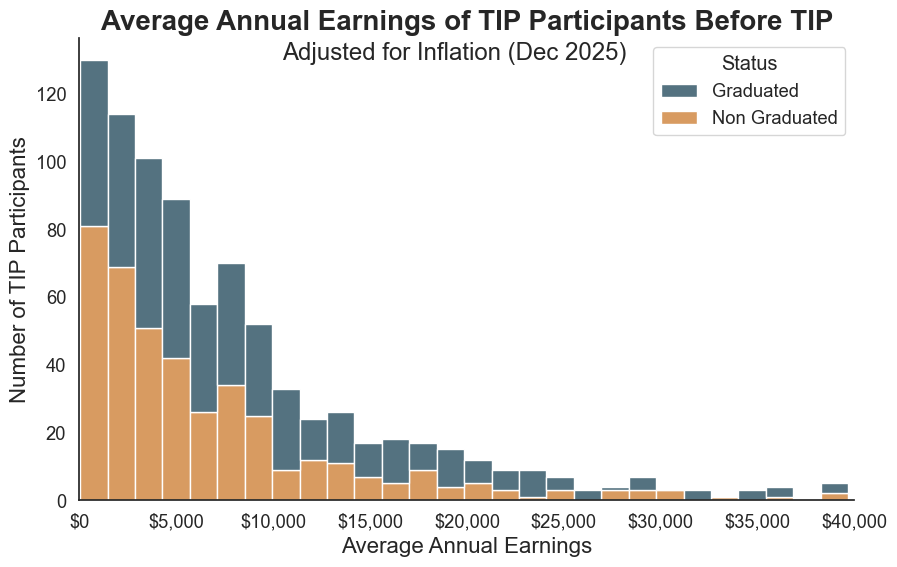

In [97]:
earnings = df_earnings.copy()
earnings = pd.merge(
    earnings,
    df[['tip_id', 'StartDate', 'Status']],
    on='tip_id',
    how='left'
)


earnings = earnings[(earnings['Status'] == 'Graduated') | (earnings['Status'] == 'Non Graduated')]
earnings = earnings[earnings['year_quarter_dt'] < earnings['StartDate']]
earnings.reset_index(drop=True, inplace=True)

earnings = earnings.groupby(['tip_id', 'year'])['adjusted_earnings'].sum().reset_index()
earnings = earnings.groupby('tip_id', as_index=False)['adjusted_earnings'].mean()

earnings = pd.merge(
    earnings,
    df[['tip_id', 'Status']].drop_duplicates(),
    on='tip_id',
    how='left'
)

status_order = ["Graduated", "Non Graduated"]
earnings['Status'] = pd.Categorical(earnings['Status'], categories=status_order, ordered=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=earnings[(earnings['adjusted_earnings'] > 0) & (earnings['adjusted_earnings'] < 40000)],
    x='adjusted_earnings',
    bins=28,
    hue='Status',
    multiple='stack'
)
sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.xlabel('Average Annual Earnings', fontdict={'fontsize': 16})
plt.title('Average Annual Earnings of TIP Participants Before TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.suptitle('Adjusted for Inflation (Dec 2025)', fontdict={'fontsize': 14}, y = 0.875)
plt.show()

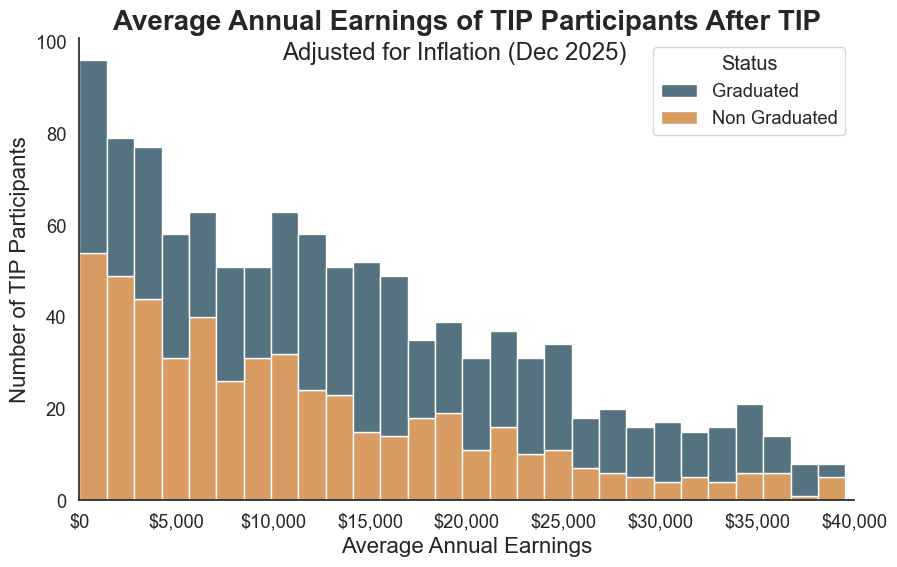

In [99]:
earnings = df_earnings.copy()
earnings = pd.merge(
    earnings,
    df[['tip_id', 'StartDate', 'Status']],
    on='tip_id',
    how='left'
)

earnings = earnings[(earnings['Status'] == 'Graduated') | (earnings['Status'] == 'Non Graduated')]
earnings = earnings[earnings['year_quarter_dt'] > earnings['StartDate']]
earnings.reset_index(drop=True, inplace=True)

earnings = earnings.groupby(['tip_id', 'year'])['adjusted_earnings'].sum().reset_index()
earnings = earnings.groupby('tip_id', as_index=False)['adjusted_earnings'].mean()

earnings = pd.merge(
    earnings,
    df[['tip_id', 'Status']].drop_duplicates(),
    on='tip_id',
    how='left'
)

status_order = ["Graduated", "Non Graduated"]
earnings['Status'] = pd.Categorical(earnings['Status'], categories=status_order, ordered=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=earnings[(earnings['adjusted_earnings'] > 0) & (earnings['adjusted_earnings'] < 40000)],
    x='adjusted_earnings',
    bins=28,
    hue='Status',
    multiple='stack'
)
sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.xlabel('Average Annual Earnings', fontdict={'fontsize': 16})
plt.suptitle('Adjusted for Inflation (Dec 2025)', fontdict={'fontsize': 14}, y = 0.875)
plt.title('Average Annual Earnings of TIP Participants After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.show()

In [100]:
df['Age'] = (df['StartDate'] - df['DOB']).dt.days / 365.25
curr_df = df[(df['Status'] == 'Graduated') | (df['Status'] == 'Non Graduated')]

In [101]:
max_date = '2026-02-14'

def valid_years(row):
    if not pd.isnull(row['GraduatedDate']):
        return (pd.to_datetime(max_date) - row['GraduatedDate']).days / 365.25
    elif not pd.isnull(row['EndDate']):
        return (pd.to_datetime(max_date) - row['EndDate']).days / 365.25
    elif not pd.isnull(row['StartDate']):
        return (pd.to_datetime(max_date) - row['StartDate']).days / 365.25
    elif not pd.isnull(row['InterviewedDate']):
        return (pd.to_datetime(max_date) - row['InterviewedDate']).days / 365.25
    else:
        return None

df['ValidYears'] = df.apply(valid_years, axis=1)
df.sample(10)

,tip_id,DOB,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,Status,census_tract,gender,race,has_employment,Alt_Status,Age,ValidYears
1533,1820,1999-08-16,2023-10-13,2023-07-13,2023-07-17,2023-10-13,Yes,Carpentry,2023-07-13,Graduated,4.200312e+10,Male,Black,True,Graduated,23.917864,2.340862
1024,1304,2000-01-08,2021-11-10,2021-04-27,2021-05-10,2021-11-10,No,Introduction to Masonry,2021-04-27,Graduated,4.200348e+10,Male,Black,True,Graduated,21.336071,4.262834
193,207,1989-09-06,2015-02-27,NaT,2014-12-09,2015-02-27,No,Introduction to Masonry,2018-07-12,Graduated,4.200356e+10,Male,Black,True,Graduated,25.256674,10.965092
1173,1457,1998-09-09,2022-04-15,2022-01-27,2022-02-02,2022-04-15,No,Introduction to Masonry,2022-01-27,Graduated,4.200760e+10,Male,Black,True,Graduated,23.400411,3.835729
263,313,1990-10-09,NaT,NaT,2015-10-13,2015-10-16,Yes,Introduction to Masonry,2018-07-12,Non Graduated,4.200356e+10,Female,Black,True,Non Graduated or Interviewed,25.010267,10.332649
563,732,1989-08-31,2018-07-27,NaT,2018-05-21,2018-07-27,No,Introduction to Masonry,2018-07-12,Graduated,4.200351e+10,Male,Black,True,Graduated,28.720055,7.553730
1529,1816,1999-06-30,NaT,2023-07-06,2023-07-17,2023-09-08,No,Carpentry,2023-07-06,Non Graduated,4.200356e+10,Male,Black,True,Non Graduated or Interviewed,24.046543,2.436687
77,84,1980-03-20,NaT,NaT,2014-05-05,2014-05-05,No,Introduction to Masonry,2018-07-12,Non Graduated,4.200356e+10,Male,Black,True,Non Graduated or Interviewed,34.124572,11.780972
1906,2203,2004-08-12,NaT,2024-10-02,NaT,NaT,No,Introduction to Masonry,2024-10-02,Interviewed,4.200313e+10,Male,Black,False,Non Graduated or Interviewed,NaN,1.368925
829,1098,1996-04-13,2020-06-12,2020-01-23,2020-01-27,2020-06-12,No,Introduction to Masonry,2020-01-23,Graduated,4.200356e+10,Male,Black,True,Graduated,23.789185,5.675565


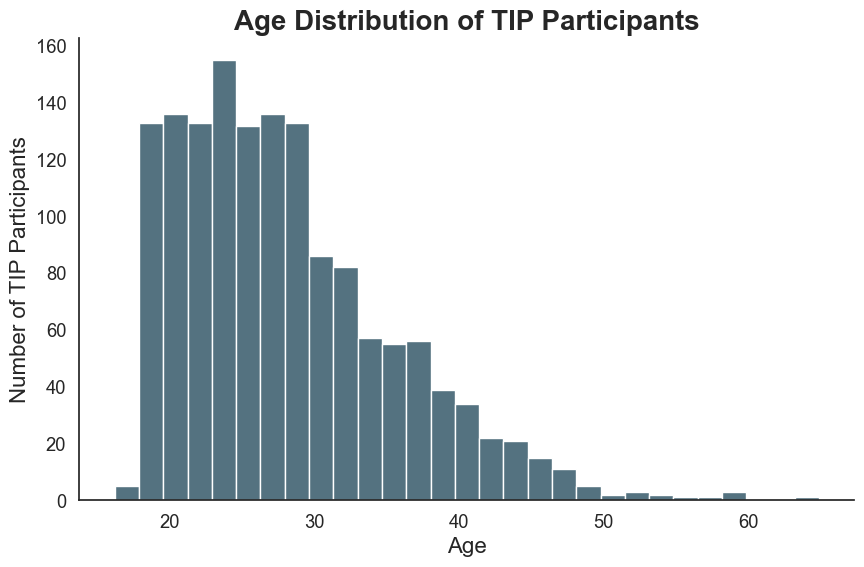

In [102]:
ages = curr_df['Age'].dropna()
ages = ages[ages > 5]
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(ages)
sns.despine()
plt.title('Age Distribution of TIP Participants', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Age', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.show()

In [103]:
ages.describe()

count    1459.000000
mean       28.095429
std         7.440317
min        16.213552
25%        22.487337
50%        26.828200
75%        32.254620
max        64.876112
Name: Age, dtype: float64

In [104]:
df['StartYear'] = df.apply(lambda x: int(x['StartDate'].year) if not pd.isnull(x['StartDate']) else int(x['InterviewedDate'].year), axis=1)

C:\Users\13429\AppData\Local\Temp\ipykernel_1204\1722155805.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  graph_counts = df.groupby(['StartYear', 'Status']).size().unstack(fill_value=0)


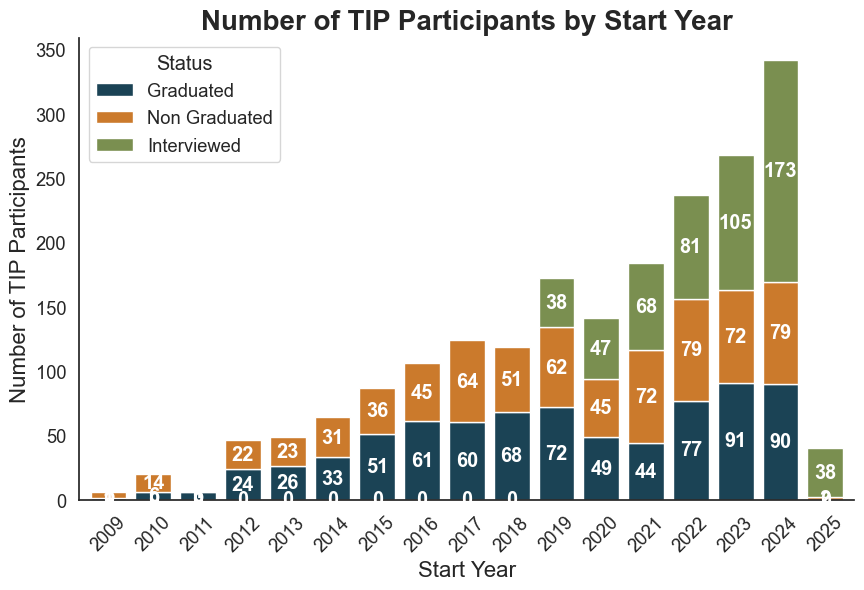

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))

status_order = ["Graduated", "Non Graduated", "Interviewed"]
df['Status'] = pd.Categorical(df['Status'], categories=status_order, ordered=True)

graph_counts = df.groupby(['StartYear', 'Status']).size().unstack(fill_value=0) 
graph_counts.plot(kind='bar', stacked=True, ax=ax, width=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontweight='bold')

sns.despine()
plt.xticks(rotation=45)
plt.title('Number of TIP Participants by Start Year', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Start Year', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.show()


In [107]:
df_convictions = pd.read_csv('TIP_MergedSentencingData.csv', parse_dates=['DOF', 'DOS', 'StartDate', 'InterviewedDate', 'EndDate', 'GraduatedDate'])
df_convictions = df_convictions[df_convictions['offense_indicator'] == 1]
df_convictions['OffenseBeforeStart'] = df_convictions.apply(lambda x: x['DOS'] < x['StartDate'] if not pd.isnull(x['StartDate']) else (x['DOS'] < x['InterviewedDate'] if not pd.isnull(x['InterviewedDate']) else False), axis=1)

In [108]:
df['OffenseBeforeStart'] = df['tip_id'].apply(lambda x: x in df_convictions[df_convictions['OffenseBeforeStart'] == True]['tip_id'].unique())

C:\Users\13429\AppData\Local\Temp\ipykernel_1204\1547725093.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = grouped_df.groupby(['StartYear', 'Status'])['OffenseBeforeStart'].mean().reset_index()
C:\Users\13429\AppData\Local\Temp\ipykernel_1204\1547725093.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for status, subset in grouped_df.groupby('Status'):


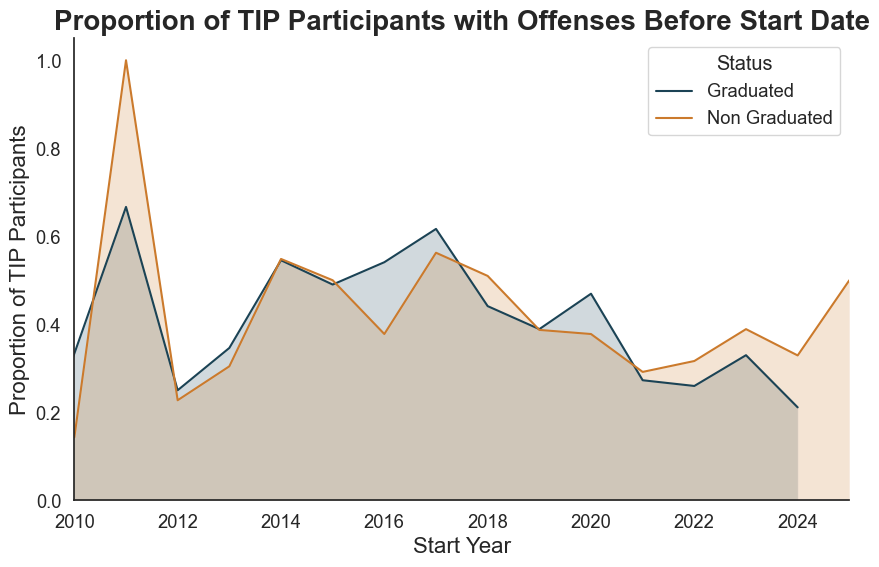

In [112]:
fig, ax = plt.subplots(figsize=(10, 6))

grouped_df = df[df['Status'] != 'Interviewed'].copy()
grouped_df['Status'] = pd.Categorical(grouped_df['Status'], categories=["Graduated", "Non Graduated"], ordered=True)

grouped_df = grouped_df.groupby(['StartYear', 'Status'])['OffenseBeforeStart'].mean().reset_index()
sns.lineplot(
    data=grouped_df,
    x='StartYear',
    y='OffenseBeforeStart',
    hue='Status',
    ax=ax
)
for status, subset in grouped_df.groupby('Status'):
    ax.fill_between(
        subset['StartYear'], subset['OffenseBeforeStart'], 0, alpha=0.2  
    )

sns.despine()

plt.title('Proportion of TIP Participants with Offenses Before Start Date', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Start Year', fontdict={'fontsize': 16})
plt.ylabel('Proportion of TIP Participants', fontdict={'fontsize': 16})
plt.ylim(0, 1.05)
plt.xlim(2010, 2025)
plt.show()

In [113]:
df_arrests = pd.read_csv('arrest_data.csv', parse_dates=['ArrestDate', 'StartDate', 'EndDate', 'InterviewedDate', 'GraduatedDate'])
df_arrests['ArrestBeforeStart'] = df_arrests.apply(lambda x: x['ArrestDate'] < x['StartDate'] if not pd.isnull(x['StartDate']) else (x['ArrestDate'] < x['InterviewedDate'] if not pd.isnull(x['InterviewedDate']) else False), axis=1)

In [114]:
df['ArrestBeforeStart'] = df['tip_id'].apply(lambda x: x in df_arrests[df_arrests['ArrestBeforeStart'] == True]['tip_id'].unique())

C:\Users\13429\AppData\Local\Temp\ipykernel_1204\3009478391.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = grouped_df.groupby(['StartYear', 'Status'])['ArrestBeforeStart'].mean().reset_index()
C:\Users\13429\AppData\Local\Temp\ipykernel_1204\3009478391.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for status, subset in grouped_df.groupby('Status'):


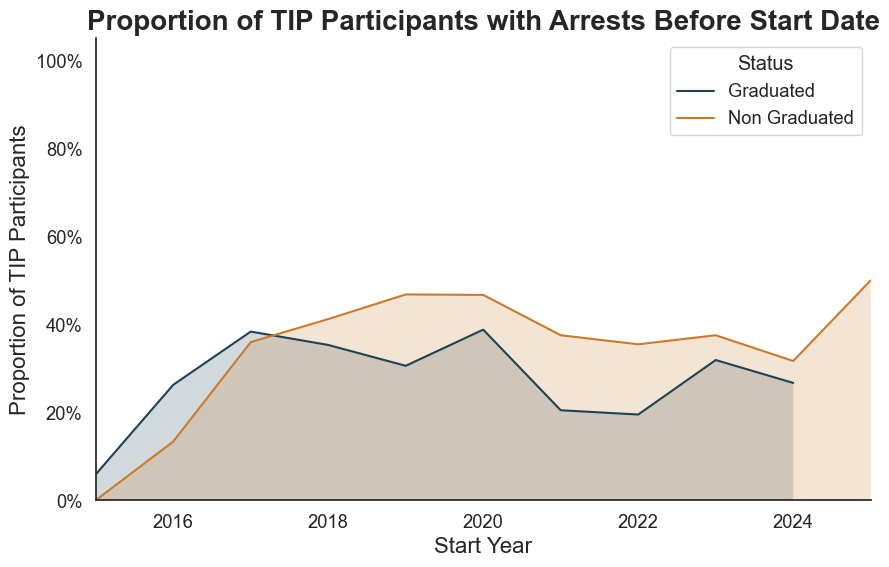

In [116]:
fig, ax = plt.subplots(figsize=(10, 6))

grouped_df = df[df['Status'] != 'Interviewed'].copy()
grouped_df['Status'] = pd.Categorical(grouped_df['Status'], categories=["Graduated", "Non Graduated"], ordered=True)

grouped_df = grouped_df.groupby(['StartYear', 'Status'])['ArrestBeforeStart'].mean().reset_index()
sns.lineplot(
    data=grouped_df,
    x='StartYear',
    y='ArrestBeforeStart',
    hue='Status',
    ax=ax
)
for status, subset in grouped_df.groupby('Status'):
    ax.fill_between(
        subset['StartYear'], subset['ArrestBeforeStart'], 0, alpha=0.2  
    )

sns.despine()

ax.yaxis.set_major_formatter('{:.0%}'.format)
plt.title('Proportion of TIP Participants with Arrests Before Start Date', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Start Year', fontdict={'fontsize': 16})
plt.ylabel('Proportion of TIP Participants', fontdict={'fontsize': 16})
plt.ylim(0, 1.05)
plt.xlim(2015, 2025)
plt.show()

In [117]:
df_convictions = pd.merge(
    df_convictions,
    df[['tip_id', 'Status', 'ValidYears']],
    on='tip_id',
    how='left'
)

In [118]:
df_convictions_ogs = df_convictions.dropna(subset=['Status']).copy()
df_convictions_ogs = df_convictions_ogs[df_convictions_ogs['OffenseBeforeStart'] == True]
df_convictions_ogs['StartYear'] = df_convictions_ogs.apply(lambda x: x['StartDate'].year if not pd.isnull(x['StartDate']) else x['InterviewedDate'].year, axis=1)
df_convictions_ogs = df_convictions_ogs[df_convictions_ogs['Status'] != 'Interviewed']
df_convictions_ogs['Status'] = pd.Categorical(df_convictions_ogs['Status'], categories=["Graduated", "Non Graduated"], ordered=True)
df_convictions_ogs['OGS'] = df_convictions_ogs['OGS'].astype(int)

C:\Users\13429\AppData\Local\Temp\ipykernel_1204\1446693432.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ogs_df = pd.DataFrame(df_convictions_ogs.groupby(['OGS', 'Status']).size()).reset_index()


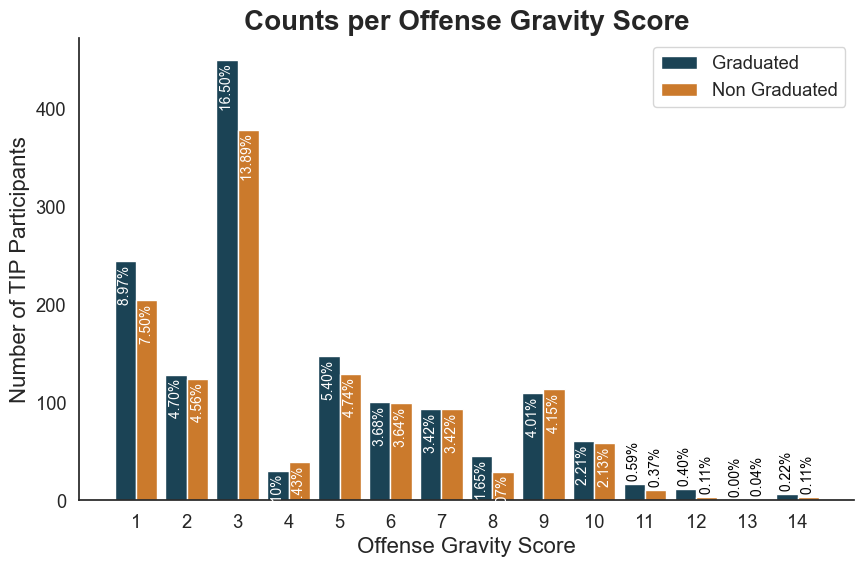

In [119]:
ogs_df = pd.DataFrame(df_convictions_ogs.groupby(['OGS', 'Status']).size()).reset_index()
ogs_df.columns = ['OGS', 'Status', 'Count']
ogs_df['Percentage'] = ogs_df['Count'] / ogs_df['Count'].sum()
ogs_df = ogs_df.pivot(index='OGS', columns='Status', values=['Percentage', 'Count'])
ogs_df.columns = ['Graduated_Percentage', 'Non Graduated_Percentage', 'Graduated_Count', 'Non Graduated_Count']
ogs_df = ogs_df.reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(ogs_df))

bar_width = 0.42

plt.bar(
    x_indexes - bar_width / 2,
    ogs_df['Graduated_Count'],
    width=bar_width,
    label='Graduated',
    color=TIP_colors[0]
)

plt.bar(
    x_indexes + bar_width / 2,
    ogs_df['Non Graduated_Count'],
    width=bar_width,
    label='Non Graduated',
    color=TIP_colors[1]
)

for i, (x, y, upper, y2, upper2) in enumerate(zip(x_indexes, ogs_df['Graduated_Percentage'], ogs_df['Graduated_Count'], ogs_df['Non Graduated_Percentage'], ogs_df['Non Graduated_Count'])):
    if i >= 10:
        continue
    plt.text(x - bar_width / 2, upper + 0.01, f'{y:.2%} ', ha='center', va='top', fontsize=10, rotation=90, color='white')
    plt.text(x + bar_width / 2, upper2 + 0.01, f'{y2:.2%} ', ha='center', va='top', fontsize=10, rotation=90, color='white')

for i, (x, y, upper, y2, upper2) in enumerate(zip(x_indexes, ogs_df['Graduated_Percentage'], ogs_df['Graduated_Count'], ogs_df['Non Graduated_Percentage'], ogs_df['Non Graduated_Count'])):
    if i < 10:
        continue
    plt.text(x - bar_width / 2, upper + 0.01, f' {y:.2%}', ha='center', va='bottom', fontsize=10, rotation=90, color='black')
    plt.text(x + bar_width / 2, upper2 + 0.01, f' {y2:.2%}', ha='center', va='bottom', fontsize=10, rotation=90, color='black')

sns.despine()

plt.xticks(ticks=x_indexes, labels=ogs_df['OGS'], rotation=0)
plt.legend()
plt.title('Counts per Offense Gravity Score', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Offense Gravity Score', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.show()

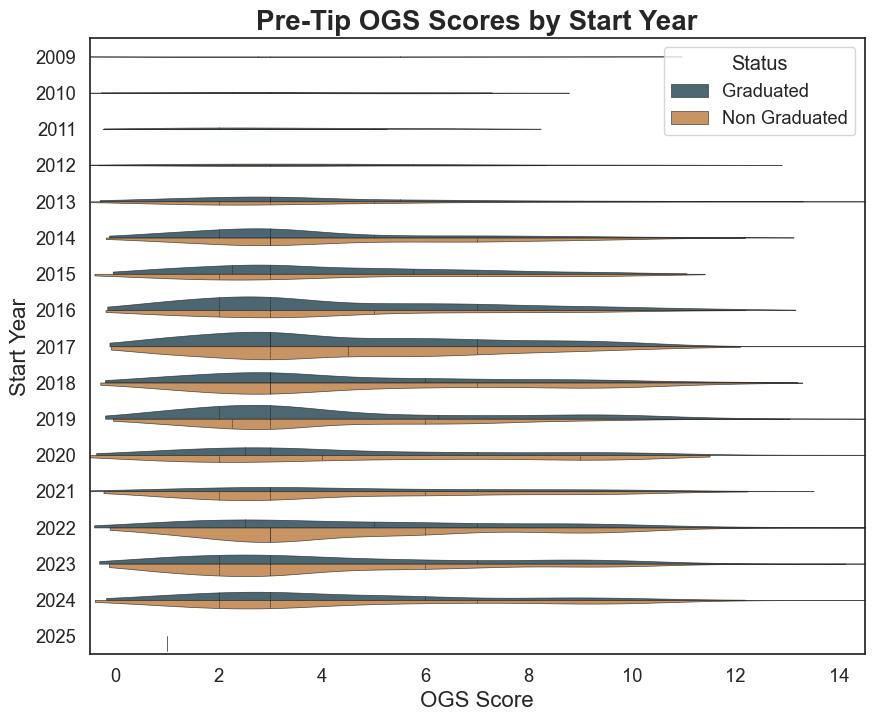

In [120]:
plt.figure(figsize=(10, 8))

sns.violinplot(
    data = df_convictions_ogs,
    y='StartYear',
    x='OGS',
    hue='Status',
    split=True,
    inner='quart',
    orient='h',
    saturation=0.8,
    dodge=True,
    cut=1.1,
    density_norm='count',
    linewidth=0.5,
    alpha=0.8
)

plt.title('Pre-Tip OGS Scores by Start Year', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.ylabel('Start Year', fontdict={'fontsize': 16})
plt.xlabel('OGS Score', fontdict={'fontsize': 16})
plt.xlim(-0.5, 14.5)
plt.show()

In [121]:
def years_since_TIP(row):
    val = 0
    dof = row['DOF']
    if not pd.isnull(row['StartDate']):
        start = row['StartDate']
    else:
        start = row['InterviewedDate']
    if not pd.isnull(row['GraduatedDate']):
        end = row['GraduatedDate']
    else:
        end = row['EndDate']

    if pd.isnull(start) and pd.isnull(end):
        return None

    if dof > start:
        val = (dof - end).days/365.2425
    elif dof < start:
        val = -(start - dof).days/365.2425
    return val

df_convictions['YearsSinceTIP'] = df_convictions.apply(years_since_TIP, axis=1)

In [100]:
def abs_min(list_x):
    return int(round(min(list_x, key=lambda x: abs(x))))

offense = df[df['tip_id'].isin(df_convictions['tip_id'].unique())].copy()
offense = pd.merge(
    offense,
    df_convictions[['DOF','DOS', 'tip_id', 'YearsSinceTIP', 'OGS']],
    on='tip_id',
    how='left'
)

offense = offense.dropna(subset=['YearsSinceTIP'])

offense_graduates = offense[offense['Status'] == 'Graduated'].copy()
offense_non_graduates = offense[offense['Status'] == 'Non Graduated'].copy()
offense_interviewed = offense[offense['Status'] == 'Interviewed'].copy()

offense_graduates['YearsSinceTIP'] = offense_graduates['YearsSinceTIP'].astype(int)
offense_non_graduates['YearsSinceTIP'] = offense_non_graduates['YearsSinceTIP'].astype(int)
offense_interviewed['YearsSinceTIP'] = offense_interviewed['YearsSinceTIP'].astype(int)

graduates_by_tip = offense_graduates.groupby('tip_id').agg({'YearsSinceTIP': abs_min}).reset_index()
non_graduates_by_tip = offense_non_graduates.groupby('tip_id').agg({'YearsSinceTIP': abs_min}).reset_index()
interviewed_by_tip = offense_interviewed.groupby('tip_id').agg({'YearsSinceTIP': abs_min}).reset_index()

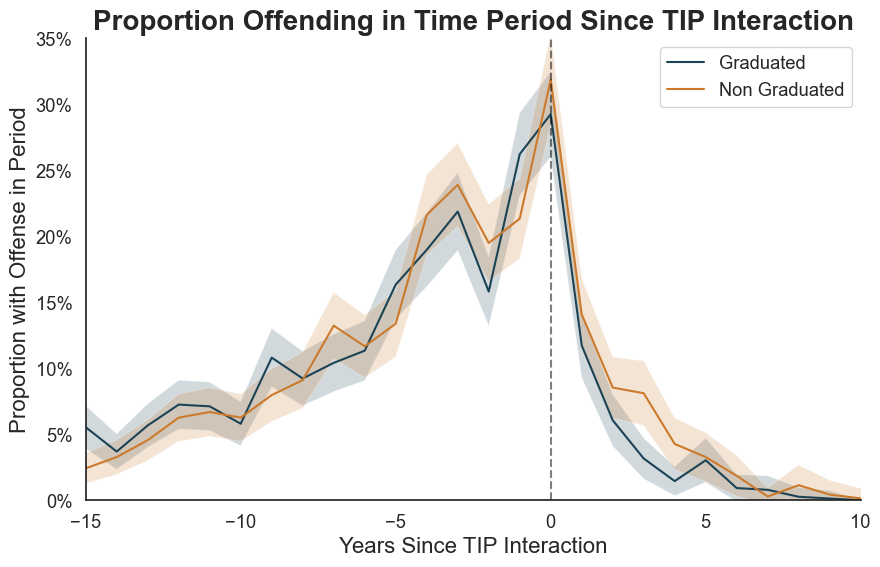

In [101]:
graduate_rate = offense_graduates.groupby('YearsSinceTIP').size() / df[df['Status'] == 'Graduated'].tip_id.nunique()
graduate_rate = graduate_rate.reset_index()
graduate_rate.columns = ['YearsSinceTIP', 'OffenseRate']

non_graduate_rate = offense_non_graduates.groupby('YearsSinceTIP').size() / df[df['Status'] == 'Non Graduated'].tip_id.nunique()
non_graduate_rate = non_graduate_rate.reset_index()
non_graduate_rate.columns = ['YearsSinceTIP', 'OffenseRate']

interviewed_rate = offense_interviewed.groupby('YearsSinceTIP').size() / df[df['Status'] == 'Interviewed'].tip_id.nunique()
interviewed_rate = interviewed_rate.reset_index()
interviewed_rate.columns = ['YearsSinceTIP', 'OffenseRate']

for i in range(min(min(graduate_rate['YearsSinceTIP'].values), min(non_graduate_rate['YearsSinceTIP'].values)), max(max(graduate_rate['YearsSinceTIP'].values), max(non_graduate_rate['YearsSinceTIP'].values)) + 1):
    if i not in graduate_rate['YearsSinceTIP'].values:
        graduate_rate = pd.concat([graduate_rate, pd.DataFrame({'YearsSinceTIP' : [i], 'OffenseRate' : [0]})])

    if i not in non_graduate_rate['YearsSinceTIP'].values:
        non_graduate_rate = pd.concat([non_graduate_rate, pd.DataFrame({'YearsSinceTIP' : [i], 'OffenseRate' : [0]})])

    if i not in interviewed_rate['YearsSinceTIP'].values:
        interviewed_rate = pd.concat([interviewed_rate, pd.DataFrame({'YearsSinceTIP' : [i], 'OffenseRate' : [0]})])

graduate_rate = graduate_rate.sort_values('YearsSinceTIP').reset_index(drop=True)
non_graduate_rate = non_graduate_rate.sort_values('YearsSinceTIP').reset_index(drop=True)
interviewed_rate = interviewed_rate.sort_values('YearsSinceTIP').reset_index(drop=True)

graduate_rate['Sample Size'] = graduate_rate['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique())
non_graduate_rate['Sample Size'] = non_graduate_rate['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique())
interviewed_rate['Sample Size'] = interviewed_rate['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Interviewed')].tip_id.nunique())

graduate_rate['upper_CI'] = graduate_rate['OffenseRate'] + 1.96 * np.sqrt(graduate_rate['OffenseRate'] * (1 - graduate_rate['OffenseRate']) / graduate_rate['Sample Size'])
graduate_rate['lower_CI'] = graduate_rate['OffenseRate'] - 1.96 * np.sqrt(graduate_rate['OffenseRate'] * (1 - graduate_rate['OffenseRate']) / graduate_rate['Sample Size'])
non_graduate_rate['upper_CI'] = non_graduate_rate['OffenseRate'] + 1.96 * np.sqrt(non_graduate_rate['OffenseRate'] * (1 - non_graduate_rate['OffenseRate']) / non_graduate_rate['Sample Size'])
non_graduate_rate['lower_CI'] = non_graduate_rate['OffenseRate'] - 1.96 * np.sqrt(non_graduate_rate['OffenseRate'] * (1 - non_graduate_rate['OffenseRate']) / non_graduate_rate['Sample Size'])
interviewed_rate['upper_CI'] = interviewed_rate['OffenseRate'] + 1.96 * np.sqrt(interviewed_rate['OffenseRate'] * (1 - interviewed_rate['OffenseRate']) / interviewed_rate['Sample Size'])
interviewed_rate['lower_CI'] = interviewed_rate['OffenseRate'] - 1.96 * np.sqrt(interviewed_rate['OffenseRate'] * (1 - interviewed_rate['OffenseRate']) / interviewed_rate['Sample Size'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=graduate_rate,
    x='YearsSinceTIP',
    y='OffenseRate',
    ax=ax,
    label='Graduated'
)

sns.lineplot(
    data=non_graduate_rate,
    x='YearsSinceTIP',
    y='OffenseRate',
    ax=ax,
    label='Non Graduated'
)

# sns.lineplot(
#     data=interviewed_rate,
#     x='YearsSinceTIP',
#     y='OffenseRate',
#     ax=ax,
#     label='Interviewed'
# )

plt.fill_between(
    graduate_rate['YearsSinceTIP'],
    graduate_rate['lower_CI'],
    graduate_rate['upper_CI'],
    alpha=0.2
)

plt.fill_between(
    non_graduate_rate['YearsSinceTIP'],
    non_graduate_rate['lower_CI'],
    non_graduate_rate['upper_CI'],
    alpha=0.2
)

# plt.fill_between(
#     interviewed_rate['YearsSinceTIP'],
#     interviewed_rate['lower_CI'],
#     interviewed_rate['upper_CI'],
#     alpha=0.2
# )

plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

sns.despine()

ax.yaxis.set_major_formatter('{:.0%}'.format)
plt.title('Proportion Offending in Time Period Since TIP Interaction', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Years Since TIP Interaction', fontdict={'fontsize': 16})
plt.ylabel('Proportion with Offense in Period', fontdict={'fontsize': 16})
plt.ylim(0, 0.35)
plt.xlim(-15, 10)
plt.show()

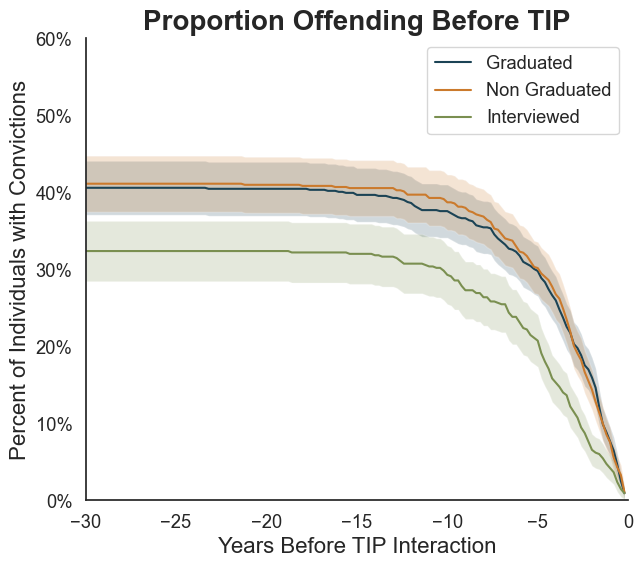

In [102]:
data_before = []
for i in np.arange(-30, 0, 0.2):
    i = round(i, 1)
    curr_grads = df_convictions[(df_convictions['YearsSinceTIP'] >= i) & (df_convictions['YearsSinceTIP'] < 0) & (df_convictions['Status'] == 'Graduated')].copy()
    curr_non_grads = df_convictions[(df_convictions['YearsSinceTIP'] >= i) & (df_convictions['YearsSinceTIP'] < 0) & (df_convictions['Status'] == 'Non Graduated')].copy()
    curr_interviewed = df_convictions[(df_convictions['YearsSinceTIP'] >= i) & (df_convictions['YearsSinceTIP'] < 0) & (df_convictions['Status'] == 'Interviewed')].copy()
    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df[df['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df[df['Status'] == 'Non Graduated'].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : curr_interviewed['tip_id'].nunique() / df[df['Status'] == 'Interviewed'].tip_id.nunique()
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0.2, 30.2, 0.2):
    curr_grads = df_convictions[(df_convictions['YearsSinceTIP'] >= 0) & (df_convictions['YearsSinceTIP'] < i) & (df_convictions['Status'] == 'Graduated') & (df_convictions['ValidYears'] > i)].copy()
    curr_non_grads = df_convictions[(df_convictions['YearsSinceTIP'] >= 0) & (df_convictions['YearsSinceTIP'] < i) & (df_convictions['Status'] == 'Non Graduated') & (df_convictions['ValidYears'] > i)].copy()
    curr_interviewed = df_convictions[(df_convictions['YearsSinceTIP'] >= 0) & (df_convictions['YearsSinceTIP'] < i) & (df_convictions['Status'] == 'Interviewed') & (df_convictions['ValidYears'] > i)].copy()

    graduate_pop_size = df[(df['Status'] == 'Graduated') & (df['ValidYears'] > i)].tip_id.nunique()
    non_graduate_pop_size = df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > i)].tip_id.nunique()
    interviewed_pop_size = df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > i)].tip_id.nunique()

    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : (curr_grads['tip_id'].nunique() / graduate_pop_size) if graduate_pop_size > 0 else 0,
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : (curr_non_grads['tip_id'].nunique() / non_graduate_pop_size) if non_graduate_pop_size > 0 else 0,
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : (curr_interviewed['tip_id'].nunique() / interviewed_pop_size) if interviewed_pop_size > 0 else 0
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Interviewed_Upper_CI'] = data_before['Interviewed Percent'] + 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())
data_before['Interviewed_Lower_CI'] = data_before['Interviewed Percent'] - 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Interviewed_Upper_CI'] = data_after['Interviewed Percent'] + 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Interviewed')].tip_id.nunique()))
data_after['Interviewed_Lower_CI'] = data_after['Interviewed Percent'] - 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Interviewed')].tip_id.nunique()))


fig, ax = plt.subplots(figsize=(7, 6))

sns.lineplot(
    data=data_before,
    x='YearsSinceTIP',
    y='Graduated Percent',
    ax=ax,
    label='Graduated'
)

sns.lineplot(
    data=data_before,
    x='YearsSinceTIP',
    y='Non Graduated Percent',
    ax=ax,
    label='Non Graduated'
)

sns.lineplot(
    data=data_before,
    x='YearsSinceTIP',
    y='Interviewed Percent',
    ax=ax,
    label='Interviewed'
)

plt.fill_between(
    data_before['YearsSinceTIP'],
    data_before['Graduated_Lower_CI'],
    data_before['Graduated_Upper_CI'],
    alpha=0.2
)

plt.fill_between(
    data_before['YearsSinceTIP'],
    data_before['Non Graduated_Lower_CI'],
    data_before['Non Graduated_Upper_CI'],
    alpha=0.2
)

plt.fill_between(
    data_before['YearsSinceTIP'],
    data_before['Interviewed_Lower_CI'],
    data_before['Interviewed_Upper_CI'],
    alpha=0.2
)

sns.despine()

ax.yaxis.set_major_formatter('{x:,.0%}')
plt.title('Proportion Offending Before TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Years Before TIP Interaction', fontdict={'fontsize': 16})
plt.ylabel('Percent of Individuals with Convictions', fontdict={'fontsize': 16})
plt.ylim(0, 0.6)
plt.xlim(-30, 0)
plt.show()

In [103]:
data_after[data_after['YearsSinceTIP'] > 9]

,YearsSinceTIP,Graduated,Graduated Percent,Non Graduated,Non Graduated Percent,Interviewed,Interviewed Percent,Graduated_Upper_CI,Graduated_Lower_CI,Non Graduated_Upper_CI,Non Graduated_Lower_CI,Interviewed_Upper_CI,Interviewed_Lower_CI
45,9.2,51,0.380597,45,0.343511,0,0.0,0.462807,0.298387,0.424833,0.262190,NaN,NaN
46,9.4,46,0.370968,40,0.336134,0,0.0,0.455993,0.285942,0.421009,0.251260,NaN,NaN
47,9.6,40,0.357143,36,0.324324,0,0.0,0.445884,0.268402,0.411411,0.237237,NaN,NaN
48,9.8,38,0.368932,33,0.320388,0,0.0,0.462118,0.275746,0.410505,0.230271,NaN,NaN
49,10.0,36,0.378947,31,0.322917,0,0.0,0.476502,0.281393,0.416454,0.229379,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,29.2,0,0.000000,0,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
146,29.4,0,0.000000,0,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
147,29.6,0,0.000000,0,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
148,29.8,0,0.000000,0,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


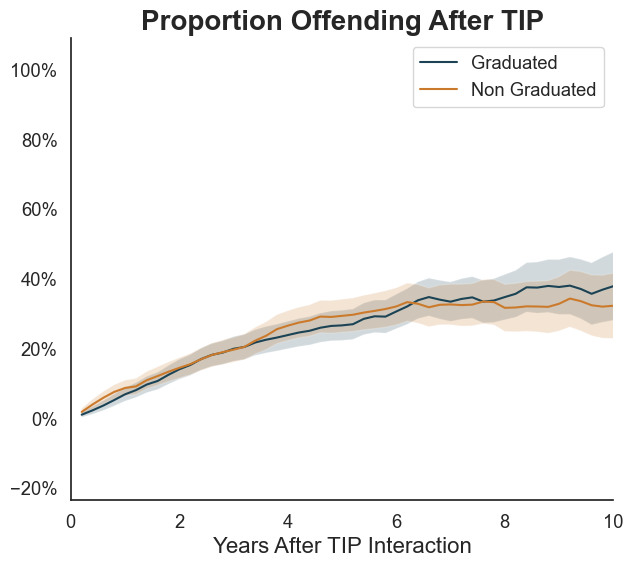

In [104]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.lineplot(
    data=data_after,
    x='YearsSinceTIP',
    y='Graduated Percent',
    ax=ax,
    label='Graduated',
)

sns.lineplot(
    data=data_after,
    x='YearsSinceTIP',
    y='Non Graduated Percent',
    ax=ax,
    label='Non Graduated',
)

plt.fill_between(
    data_after['YearsSinceTIP'],
    data_after['Graduated_Lower_CI'],
    data_after['Graduated_Upper_CI'],
    alpha=0.2
)

plt.fill_between(
    data_after['YearsSinceTIP'],
    data_after['Non Graduated_Lower_CI'],
    data_after['Non Graduated_Upper_CI'],
    alpha=0.2
)


sns.despine()

ax.yaxis.set_major_formatter('{x:,.0%}')
plt.title('Proportion Offending After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Years After TIP Interaction', fontdict={'fontsize': 16})
plt.ylabel('', fontdict={'fontsize': 1})
plt.xlim(0, 10)
plt.show()

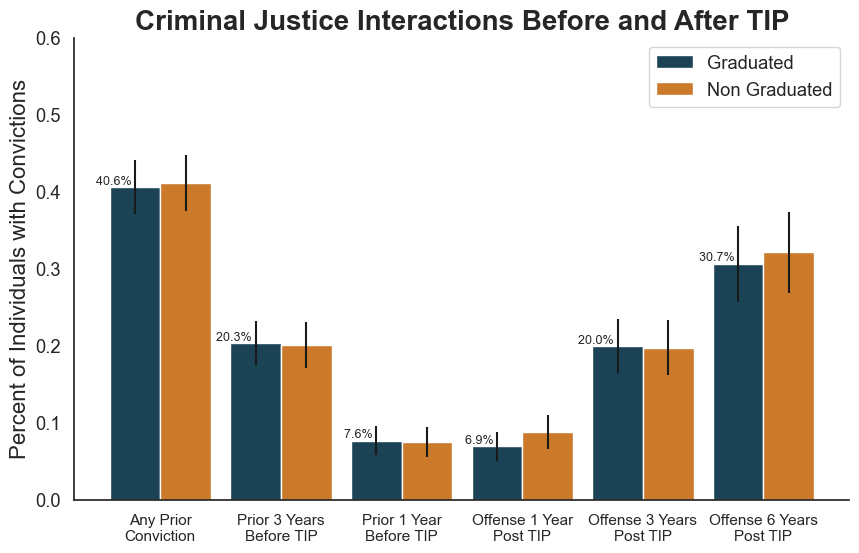

In [105]:
data_after['YearsSinceTIP'] = data_after['YearsSinceTIP'].apply(lambda x: round(x, 2))

data = pd.concat([
    data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)],
    data_after[(data_after['YearsSinceTIP'] == 1) | (data_after['YearsSinceTIP'] == 3) | (data_after['YearsSinceTIP'] == 6)]
])

data = data.drop(columns=['Interviewed', 'Interviewed Percent', 'Interviewed_Lower_CI', 'Interviewed_Upper_CI'])
data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Conviction", 
    "Prior 3 Years Before TIP", 
    "Prior 1 Year Before TIP", 
    "Offense 1 Year Post TIP", 
    "Offense 3 Years Post TIP", 
    "Offense 6 Years Post TIP"
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nConviction", 
    "Prior 3 Years\nBefore TIP", 
    "Prior 1 Year\nBefore TIP", 
    "Offense 1 Year\nPost TIP", 
    "Offense 3 Years\nPost TIP", 
    "Offense 6 Years\nPost TIP"
], rotation=0, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Criminal Justice Interactions Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Convictions', fontdict={'fontsize': 16})
plt.ylim(0, 0.6)
plt.legend()
plt.show()


In [106]:
df_arrests = pd.merge(
    df_arrests,
    df[['tip_id', 'Status', 'ValidYears']],
    on='tip_id',
    how='left'
)

In [107]:
df_arrests.columns

Index(['County', 'DocketNumber', 'OTN', 'CaseFiledDate', 'ArrestDate',
       'DefendantRace', 'DefendantEthnicity', 'DefendantGender',
       'DefendantDOB', 'DefendantZipCode', 'OffenseSequenceNumber', 'Title',
       'Section', 'SubSection', 'Description', 'OffenseDate',
       'OffenseDisposition', 'OffenseDispositionDate', 'OffenseGrade',
       'CaseDisposition', 'CaseDispositionDate',
       'DefendantAttorneyRepresentationType', 'InterviewedDate',
       'Orientation Date', 'GraduatedDate', 'CreatedDate', 'StartDate',
       'EndDate', 'DriversLicense', 'Course', 'tip_id',
       'OriginatingDocketNumber', 'OrigFiledDate', 'ArrestBeforeStart',
       'Status', 'ValidYears'],
      dtype='object')

In [108]:
df_arrests['DOF'] = df_arrests['ArrestDate']
df_arrests['YearsSinceTIP'] = df_arrests.apply(years_since_TIP, axis=1)

df_arrests.sample(3)

,County,DocketNumber,OTN,CaseFiledDate,ArrestDate,DefendantRace,DefendantEthnicity,DefendantGender,DefendantDOB,DefendantZipCode,...,DriversLicense,Course,tip_id,OriginatingDocketNumber,OrigFiledDate,ArrestBeforeStart,Status,ValidYears,DOF,YearsSinceTIP
8765,Allegheny,CP-02-CR-0001604-2022,G8935861,2022-03-07 14:32:00,2021-08-15,Black,Non Hispanic,Male,2002-02-03,15145.0,...,Yes,Introduction to Masonry,1411,MJ-05003-CR-0004445-2021,2021-08-14 00:00:00,True,Non Graduated,3.211499,2021-08-15,-0.290218
6168,Allegheny,CP-02-CR-0004899-2019,G8278896,2019-05-07 15:52:00,2019-01-10,Black,Non Hispanic,Male,2000-02-04,15212.0,...,No,Introduction to Masonry,628,MJ-05201-CR-0000017-2019,2019-01-10 16:48:00,False,Graduated,7.214237,2019-01-10,1.070522
6918,Allegheny,CP-02-CR-0007251-2019,G8315193,2019-07-08 09:21:00,2019-02-26,Black,Non Hispanic,Male,1978-12-10,15110.0,...,No,Carpentry,1647,MJ-05247-CR-0000125-2019,2019-02-26 23:22:00,True,Graduated,2.020534,2019-02-26,-3.715340


In [109]:
df_2022 = df[df['StartYear'] >= 2022].copy()

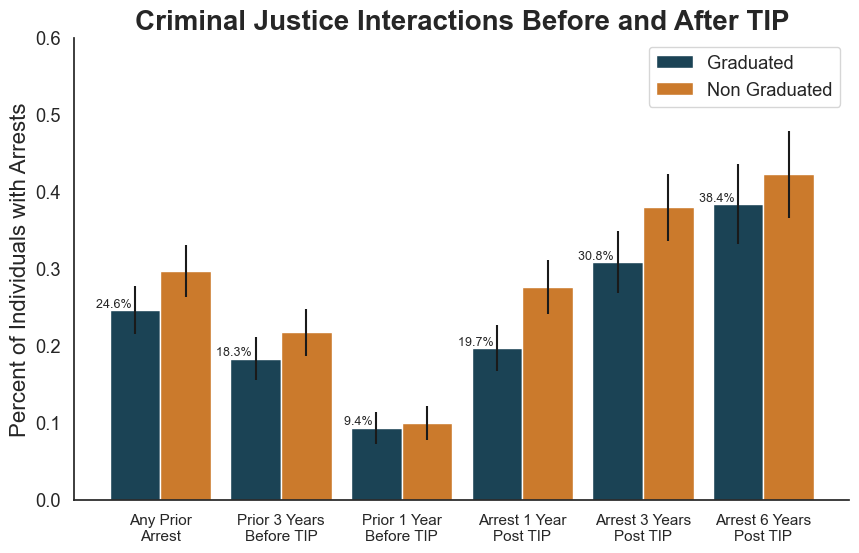

In [110]:
data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= i) & (df_arrests['YearsSinceTIP'] < 0) & (df_arrests['Status'] == 'Graduated')].copy()
    curr_non_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= i) & (df_arrests['YearsSinceTIP'] < 0) & (df_arrests['Status'] == 'Non Graduated')].copy()
    curr_interviewed = df_arrests[(df_arrests['YearsSinceTIP'] >= i) & (df_arrests['YearsSinceTIP'] < 0) & (df_arrests['Status'] == 'Interviewed')].copy()
    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df[df['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df[df['Status'] == 'Non Graduated'].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : curr_interviewed['tip_id'].nunique() / df[df['Status'] == 'Interviewed'].tip_id.nunique()
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 30.2, 0.2):
    curr_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= 0) & (df_arrests['YearsSinceTIP'] < i) & (df_arrests['Status'] == 'Graduated') & (df_arrests['ValidYears'] > i)].copy()
    curr_non_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= 0) & (df_arrests['YearsSinceTIP'] < i) & (df_arrests['Status'] == 'Non Graduated') & (df_arrests['ValidYears'] > i)].copy()
    curr_interviewed = df_arrests[(df_arrests['YearsSinceTIP'] >= 0) & (df_arrests['YearsSinceTIP'] < i) & (df_arrests['Status'] == 'Interviewed') & (df_arrests['ValidYears'] > i)].copy()

    graduate_pop_size = df[(df['Status'] == 'Graduated') & (df['ValidYears'] > i)].tip_id.nunique()
    non_graduate_pop_size = df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > i)].tip_id.nunique()
    interviewed_pop_size = df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > i)].tip_id.nunique()

    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : (curr_grads['tip_id'].nunique() / graduate_pop_size) if graduate_pop_size > 0 else 0,
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : (curr_non_grads['tip_id'].nunique() / non_graduate_pop_size) if non_graduate_pop_size > 0 else 0,
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : (curr_interviewed['tip_id'].nunique() / interviewed_pop_size) if interviewed_pop_size > 0 else 0
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Interviewed_Upper_CI'] = data_before['Interviewed Percent'] + 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())
data_before['Interviewed_Lower_CI'] = data_before['Interviewed Percent'] - 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Interviewed_Upper_CI'] = data_after['Interviewed Percent'] + 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Interviewed')].tip_id.nunique()))
data_after['Interviewed_Lower_CI'] = data_after['Interviewed Percent'] - 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Interviewed')].tip_id.nunique()))

data = pd.concat([
    data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)],
    data_after[(data_after['YearsSinceTIP'] == 1) | (data_after['YearsSinceTIP'] == 3) | (data_after['YearsSinceTIP'] == 6)]
])

data = data.drop(columns=['Interviewed', 'Interviewed Percent', 'Interviewed_Lower_CI', 'Interviewed_Upper_CI'])
data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Arrest", 
    "Prior 3 Years Before TIP", 
    "Prior 1 Year Before TIP", 
    "Arrest 1 Year Post TIP", 
    "Arrest 3 Years Post TIP", 
    "Arrest 6 Years Post TIP"
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nArrest", 
    "Prior 3 Years\nBefore TIP", 
    "Prior 1 Year\nBefore TIP", 
    "Arrest 1 Year\nPost TIP", 
    "Arrest 3 Years\nPost TIP", 
    "Arrest 6 Years\nPost TIP"
], rotation=0, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

# for i, (x, y, upper, lower) in enumerate(zip(x_indexes + width/2, data['Non Graduated Percent'], data['Non Graduated_Upper_CI'], data['Non Graduated_Lower_CI'])):
#     ax.text(x, y, f" {y:.1%}", ha='left', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Criminal Justice Interactions Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Arrests', fontdict={'fontsize': 16})
plt.ylim(0, 0.6)
plt.legend()
plt.show()


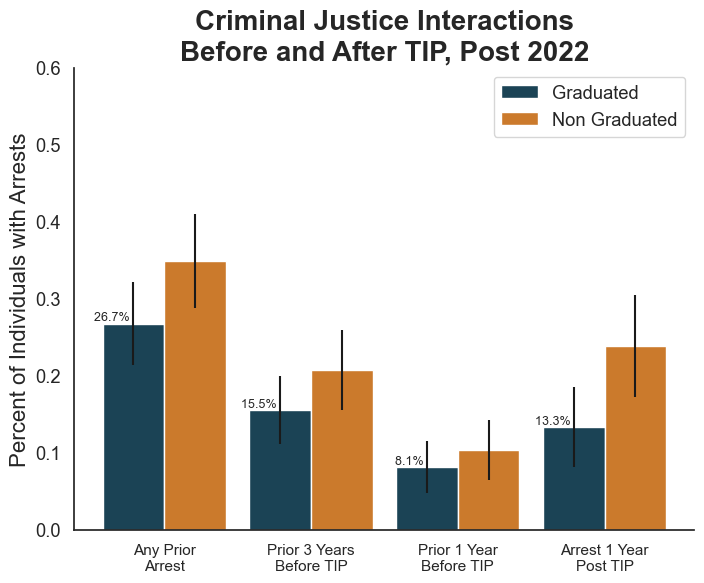

In [111]:
df_arrests_2022 = df_arrests[df_arrests['tip_id'].isin(df_2022['tip_id'])]
data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= i) & (df_arrests_2022['YearsSinceTIP'] < 0) & (df_arrests_2022['Status'] == 'Graduated')].copy()
    curr_non_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= i) & (df_arrests_2022['YearsSinceTIP'] < 0) & (df_arrests_2022['Status'] == 'Non Graduated')].copy()
    curr_interviewed = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= i) & (df_arrests_2022['YearsSinceTIP'] < 0) & (df_arrests_2022['Status'] == 'Interviewed')].copy()
    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : curr_interviewed['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique()
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 30.2, 0.2):
    curr_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= 0) & (df_arrests_2022['YearsSinceTIP'] < i) & (df_arrests_2022['Status'] == 'Graduated') & (df_arrests_2022['ValidYears'] > i)].copy()
    curr_non_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= 0) & (df_arrests_2022['YearsSinceTIP'] < i) & (df_arrests_2022['Status'] == 'Non Graduated') & (df_arrests_2022['ValidYears'] > i)].copy()
    curr_interviewed = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= 0) & (df_arrests_2022['YearsSinceTIP'] < i) & (df_arrests_2022['Status'] == 'Interviewed') & (df_arrests_2022['ValidYears'] > i)].copy()

    graduate_pop_size = df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique()
    non_graduate_pop_size = df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique()
    interviewed_pop_size = df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > i)].tip_id.nunique()

    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : (curr_grads['tip_id'].nunique() / graduate_pop_size) if graduate_pop_size > 0 else 0,
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : (curr_non_grads['tip_id'].nunique() / non_graduate_pop_size) if non_graduate_pop_size > 0 else 0,
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : (curr_interviewed['tip_id'].nunique() / interviewed_pop_size) if interviewed_pop_size > 0 else 0
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Interviewed_Upper_CI'] = data_before['Interviewed Percent'] + 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique())
data_before['Interviewed_Lower_CI'] = data_before['Interviewed Percent'] - 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Interviewed_Upper_CI'] = data_after['Interviewed Percent'] + 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Interviewed')].tip_id.nunique()))
data_after['Interviewed_Lower_CI'] = data_after['Interviewed Percent'] - 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Interviewed')].tip_id.nunique()))

data = pd.concat([
    data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)],
    data_after[(data_after['YearsSinceTIP'] == 1)]
])

data = data.drop(columns=['Interviewed', 'Interviewed Percent', 'Interviewed_Lower_CI', 'Interviewed_Upper_CI'])
data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Arrest", 
    "Prior 3 Years Before TIP", 
    "Prior 1 Year Before TIP", 
    "Arrest 1 Year Post TIP", 
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(8, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nArrest", 
    "Prior 3 Years\nBefore TIP", 
    "Prior 1 Year\nBefore TIP", 
    "Arrest 1 Year\nPost TIP", 
], rotation=0, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

# for i, (x, y, upper, lower) in enumerate(zip(x_indexes + width/2, data['Non Graduated Percent'], data['Non Graduated_Upper_CI'], data['Non Graduated_Lower_CI'])):
#     ax.text(x, y, f" {y:.1%}", ha='left', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Criminal Justice Interactions\nBefore and After TIP, Post 2022', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Arrests', fontdict={'fontsize': 16})
plt.ylim(0, 0.6)
plt.legend()
plt.show()


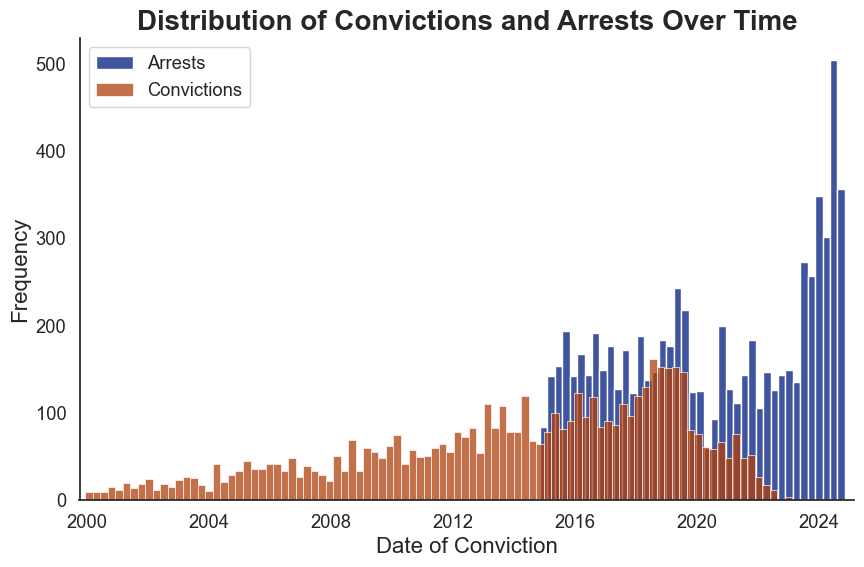

In [112]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    df_arrests['DOF'],
    binwidth=90,
    color=sns.color_palette('dark')[0]
)

sns.histplot(
    df_convictions['DOF'],
    binwidth=90,
    color=sns.color_palette('dark')[1]
)

sns.despine()

plt.title('Distribution of Convictions and Arrests Over Time', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlim(pd.Timestamp('1999-10-01'), pd.Timestamp('2025-02-28'))
plt.xlabel('Date of Conviction', fontdict={'fontsize': 16})
plt.ylabel('Frequency', fontdict={'fontsize': 16})
plt.legend(['Arrests', 'Convictions'])
plt.show()


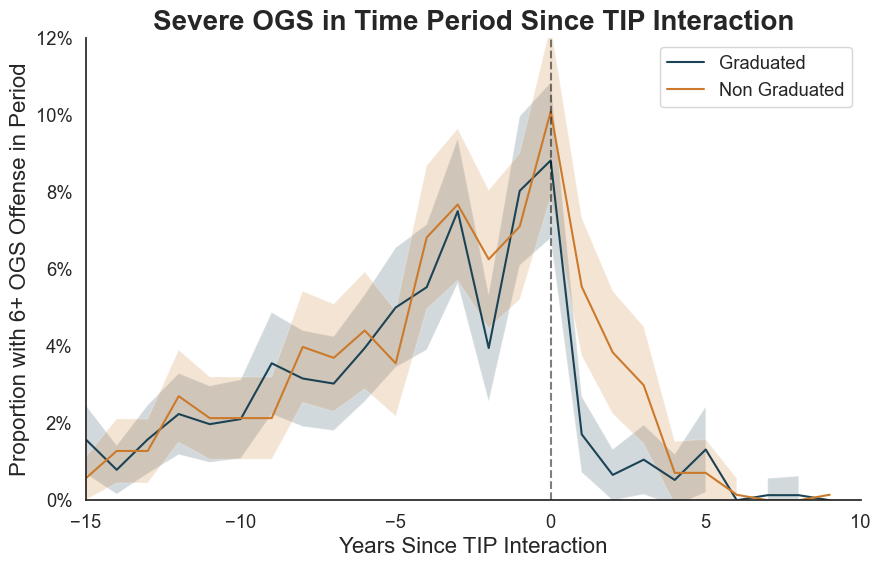

In [113]:
offense = df[df['tip_id'].isin(df_convictions['tip_id'].unique())].copy()
offense = pd.merge(
    offense,
    df_convictions[['DOF','DOS', 'tip_id', 'YearsSinceTIP', 'OGS']],
    on='tip_id',
    how='left'
)

offense = offense[offense['OGS'] >= 6]
offense = offense.dropna(subset=['YearsSinceTIP'])

offense_graduates = offense[offense['Status'] == 'Graduated'].copy()
offense_non_graduates = offense[offense['Status'] == 'Non Graduated'].copy()

offense_graduates['YearsSinceTIP'] = offense_graduates['YearsSinceTIP'].astype(int)
offense_non_graduates['YearsSinceTIP'] = offense_non_graduates['YearsSinceTIP'].astype(int)

graduates_by_tip = offense_graduates.groupby('tip_id').agg({'YearsSinceTIP': abs_min}).reset_index()
non_graduates_by_tip = offense_non_graduates.groupby('tip_id').agg({'YearsSinceTIP': abs_min}).reset_index()

graduate_rate = offense_graduates.groupby('YearsSinceTIP').size() / df[df['Status'] == 'Graduated'].tip_id.nunique()
graduate_rate = graduate_rate.reset_index()
graduate_rate.columns = ['YearsSinceTIP', 'OffenseRate']
graduate_rate['SampleSize'] = graduate_rate['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique())


non_graduate_rate = offense_non_graduates.groupby('YearsSinceTIP').size() / df[df['Status'] == 'Non Graduated'].tip_id.nunique()
non_graduate_rate = non_graduate_rate.reset_index()
non_graduate_rate.columns = ['YearsSinceTIP', 'OffenseRate']
non_graduate_rate['Sample Size'] = non_graduate_rate['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique())

for i in range(min(min(graduate_rate['YearsSinceTIP'].values), min(non_graduate_rate['YearsSinceTIP'].values)), max(max(graduate_rate['YearsSinceTIP'].values), max(non_graduate_rate['YearsSinceTIP'].values)) + 1):
    if i not in graduate_rate['YearsSinceTIP'].values:
        graduate_rate = pd.concat([graduate_rate, pd.DataFrame({'YearsSinceTIP' : [i], 'OffenseRate' : [0]})])

    if i not in non_graduate_rate['YearsSinceTIP'].values:
        non_graduate_rate = pd.concat([non_graduate_rate, pd.DataFrame({'YearsSinceTIP' : [i], 'OffenseRate' : [0]})])

graduate_rate = graduate_rate.sort_values('YearsSinceTIP').reset_index(drop=True)
non_graduate_rate = non_graduate_rate.sort_values('YearsSinceTIP').reset_index(drop=True)

graduate_rate['upper_CI'] = graduate_rate['OffenseRate'] + 1.96 * np.sqrt(graduate_rate['OffenseRate'] * (1 - graduate_rate['OffenseRate']) / graduate_rate['SampleSize'])
graduate_rate['lower_CI'] = graduate_rate['OffenseRate'] - 1.96 * np.sqrt(graduate_rate['OffenseRate'] * (1 - graduate_rate['OffenseRate']) / graduate_rate['SampleSize'])
non_graduate_rate['upper_CI'] = non_graduate_rate['OffenseRate'] + 1.96 * np.sqrt(non_graduate_rate['OffenseRate'] * (1 - non_graduate_rate['OffenseRate']) / non_graduate_rate['Sample Size'])
non_graduate_rate['lower_CI'] = non_graduate_rate['OffenseRate'] - 1.96 * np.sqrt(non_graduate_rate['OffenseRate'] * (1 - non_graduate_rate['OffenseRate']) / non_graduate_rate['Sample Size'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=graduate_rate,
    x='YearsSinceTIP',
    y='OffenseRate',
    ax=ax,
    label='Graduated'
)

sns.lineplot(
    data=non_graduate_rate,
    x='YearsSinceTIP',
    y='OffenseRate',
    ax=ax,
    label='Non Graduated'
)

plt.fill_between(
    graduate_rate['YearsSinceTIP'],
    graduate_rate['lower_CI'],
    graduate_rate['upper_CI'],
    alpha=0.2
)

plt.fill_between(
    non_graduate_rate['YearsSinceTIP'],
    non_graduate_rate['lower_CI'],
    non_graduate_rate['upper_CI'],
    alpha=0.2
)

plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

sns.despine()

ax.yaxis.set_major_formatter('{x:,.0%}')
plt.title('Severe OGS in Time Period Since TIP Interaction', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Years Since TIP Interaction', fontdict={'fontsize': 16})
plt.ylabel('Proportion with 6+ OGS Offense in Period', fontdict={'fontsize': 16})
plt.ylim(0, 0.12)
plt.xlim(-15, 10)
plt.show()

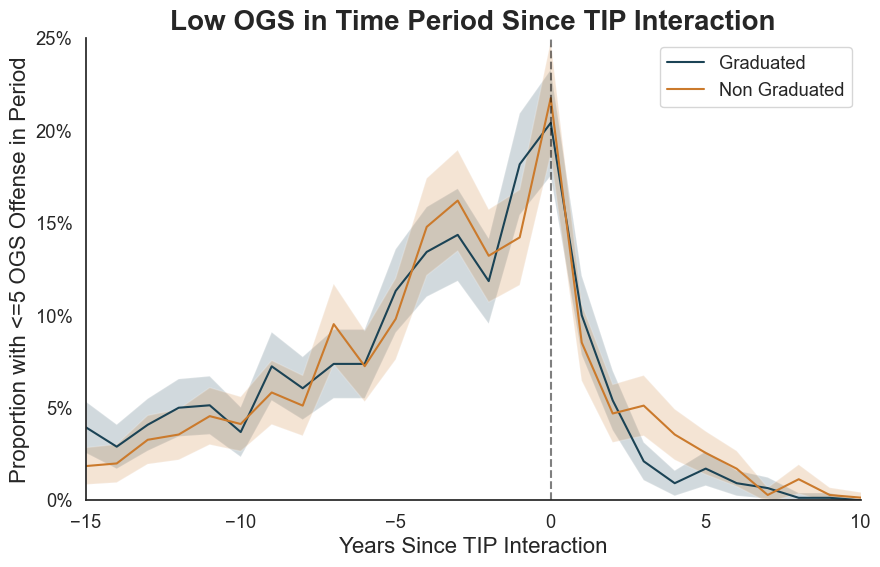

In [114]:
offense = df[df['tip_id'].isin(df_convictions['tip_id'].unique())].copy()
offense = pd.merge(
    offense,
    df_convictions[['DOF','DOS', 'tip_id', 'YearsSinceTIP', 'OGS']],
    on='tip_id',
    how='left'
)

offense = offense[offense['OGS'] < 6]
offense = offense.dropna(subset=['YearsSinceTIP'])

offense_graduates = offense[offense['Status'] == 'Graduated'].copy()
offense_non_graduates = offense[offense['Status'] == 'Non Graduated'].copy()

offense_graduates['YearsSinceTIP'] = offense_graduates['YearsSinceTIP'].astype(int)
offense_non_graduates['YearsSinceTIP'] = offense_non_graduates['YearsSinceTIP'].astype(int)

graduates_by_tip = offense_graduates.groupby('tip_id').agg({'YearsSinceTIP': abs_min}).reset_index()
non_graduates_by_tip = offense_non_graduates.groupby('tip_id').agg({'YearsSinceTIP': abs_min}).reset_index()
graduate_rate = offense_graduates.groupby('YearsSinceTIP').size() / df[df['Status'] == 'Graduated'].tip_id.nunique()
graduate_rate = graduate_rate.reset_index()
graduate_rate.columns = ['YearsSinceTIP', 'OffenseRate']

non_graduate_rate = offense_non_graduates.groupby('YearsSinceTIP').size() / df[df['Status'] == 'Non Graduated'].tip_id.nunique()
non_graduate_rate = non_graduate_rate.reset_index()
non_graduate_rate.columns = ['YearsSinceTIP', 'OffenseRate']

for i in range(min(min(graduate_rate['YearsSinceTIP'].values), min(non_graduate_rate['YearsSinceTIP'].values)), max(max(graduate_rate['YearsSinceTIP'].values), max(non_graduate_rate['YearsSinceTIP'].values)) + 1):
    if i not in graduate_rate['YearsSinceTIP'].values:
        graduate_rate = pd.concat([graduate_rate, pd.DataFrame({'YearsSinceTIP' : [i], 'OffenseRate' : [0]})])

    if i not in non_graduate_rate['YearsSinceTIP'].values:
        non_graduate_rate = pd.concat([non_graduate_rate, pd.DataFrame({'YearsSinceTIP' : [i], 'OffenseRate' : [0]})])

graduate_rate = graduate_rate.sort_values('YearsSinceTIP').reset_index(drop=True)
non_graduate_rate = non_graduate_rate.sort_values('YearsSinceTIP').reset_index(drop=True)

graduate_rate['upper_CI'] = graduate_rate['OffenseRate'] + 1.96 * np.sqrt(graduate_rate['OffenseRate'] * (1 - graduate_rate['OffenseRate']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
graduate_rate['lower_CI'] = graduate_rate['OffenseRate'] - 1.96 * np.sqrt(graduate_rate['OffenseRate'] * (1 - graduate_rate['OffenseRate']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
non_graduate_rate['upper_CI'] = non_graduate_rate['OffenseRate'] + 1.96 * np.sqrt(non_graduate_rate['OffenseRate'] * (1 - non_graduate_rate['OffenseRate']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
non_graduate_rate['lower_CI'] = non_graduate_rate['OffenseRate'] - 1.96 * np.sqrt(non_graduate_rate['OffenseRate'] * (1 - non_graduate_rate['OffenseRate']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=graduate_rate,
    x='YearsSinceTIP',
    y='OffenseRate',
    ax=ax,
    label='Graduated'
)

sns.lineplot(
    data=non_graduate_rate,
    x='YearsSinceTIP',
    y='OffenseRate',
    ax=ax,
    label='Non Graduated'
)

plt.fill_between(
    graduate_rate['YearsSinceTIP'],
    graduate_rate['lower_CI'],
    graduate_rate['upper_CI'],
    alpha=0.2
)

plt.fill_between(
    non_graduate_rate['YearsSinceTIP'],
    non_graduate_rate['lower_CI'],
    non_graduate_rate['upper_CI'],
    alpha=0.2
)

plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

sns.despine()

ax.yaxis.set_major_formatter('{x:,.0%}')
plt.title('Low OGS in Time Period Since TIP Interaction', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Years Since TIP Interaction', fontdict={'fontsize': 16})
plt.ylabel('Proportion with <=5 OGS Offense in Period', fontdict={'fontsize': 16})
plt.ylim(0, 0.25)
plt.xlim(-15, 10)
plt.show()

In [115]:
df_earnings = pd.merge(
    df_earnings,
    df[['tip_id', 'Status', 'StartDate', 'InterviewedDate', 'EndDate', 'GraduatedDate', 'ValidYears']],
    on='tip_id',
    how='left'
)

In [116]:
df_earnings['DOF'] = df_earnings['year_quarter_dt']
df_earnings['YearsSinceTIP'] = df_earnings.apply(years_since_TIP, axis=1)

df_earnings.dropna(subset=['YearsSinceTIP'], inplace=True)

df_earnings.sample(3)

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,...,year_month,adjusted_earnings,Status,StartDate,InterviewedDate,EndDate,GraduatedDate,ValidYears,DOF,YearsSinceTIP
7524,1109,20183,ABM INDUSTRY GROUPS LLC,7930,561720.0,Administrative and support and waste managemen...,Administrative and support services,Janitorial Services,Administrative and Support and Waste Managemen...,Administrative and Support Services,...,2018-01,10097.139393,Graduated,2020-02-17,2020-02-11,2020-03-06,2020-03-06,4.991102,2018-01-01,-2.127354
20,572,20174,SAGA STEAKHOUSE,97,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,...,2017-04,123.508515,Non Graduated,2017-06-13,NaT,2017-06-15,NaT,7.715264,2017-04-01,-0.199867
8398,1213,20184,ROX TRUCKING INC,12049,484220.0,Transportation and warehousing,Truck transportation,Specialized Freight (except Used Goods) Trucki...,Transportation and Warehousing,Truck Transportation,...,2018-04,15341.794773,Graduated,2020-10-12,2020-10-08,2021-01-08,2021-01-08,4.147844,2018-04-01,-2.532564


In [117]:
df_earnings_year = df_earnings.groupby(['tip_id', 'year']).agg({'earnings': 'sum'}).reset_index()
df_earnings_year

,tip_id,year,earnings
0,1,2017,310
1,1,2018,4616
2,1,2019,18309
3,1,2020,22750
4,1,2021,39138
...,...,...,...
8808,2310,2020,10811
8809,2310,2021,3443
8810,2310,2022,2920
8811,2310,2023,25339


In [118]:
data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_earnings[(df_earnings['YearsSinceTIP'] >= i) & (df_earnings['YearsSinceTIP'] < 0) & (df_earnings['Status'] == 'Graduated')].copy()
    curr_non_grads = df_earnings[(df_earnings['YearsSinceTIP'] >= i) & (df_earnings['YearsSinceTIP'] < 0) & (df_earnings['Status'] == 'Non Graduated')].copy()
    curr_interviewed = df_earnings[(df_earnings['YearsSinceTIP'] >= i) & (df_earnings['YearsSinceTIP'] < 0) & (df_earnings['Status'] == 'Interviewed')].copy()
    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df[df['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df[df['Status'] == 'Non Graduated'].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : curr_interviewed['tip_id'].nunique() / df[df['Status'] == 'Interviewed'].tip_id.nunique()
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 30.2, 0.2):
    curr_grads = df_earnings[(df_earnings['YearsSinceTIP'] >= 0) & (df_earnings['YearsSinceTIP'] < i) & (df_earnings['Status'] == 'Graduated') & (df_earnings['ValidYears'] > i)].copy()
    curr_non_grads = df_earnings[(df_earnings['YearsSinceTIP'] >= 0) & (df_earnings['YearsSinceTIP'] < i) & (df_earnings['Status'] == 'Non Graduated') & (df_earnings['ValidYears'] > i)].copy()
    curr_interviewed = df_earnings[(df_earnings['YearsSinceTIP'] >= 0) & (df_earnings['YearsSinceTIP'] < i) & (df_earnings['Status'] == 'Interviewed') & (df_earnings['ValidYears'] > i)].copy()
    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : (curr_grads['tip_id'].nunique() / df[(df['Status'] == 'Graduated') & (df['ValidYears'] > i)].tip_id.nunique()) if df[(df['Status'] == 'Graduated') & (df['ValidYears'] > i)].tip_id.nunique() > 0 else 0,
        'Graduated Sample Size': df[(df['Status'] == 'Graduated') & (df['ValidYears'] > i)].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : (curr_non_grads['tip_id'].nunique() / df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > i)].tip_id.nunique()) if df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > i)].tip_id.nunique() > 0 else 0,
        'Non Graduated Sample Size': df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > i)].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : (curr_interviewed['tip_id'].nunique() / df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > i)].tip_id.nunique()) if df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > i)].tip_id.nunique() > 0 else 0,
        'Interviewed Sample Size': df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > i)].tip_id.nunique()
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Interviewed_Upper_CI'] = data_before['Interviewed Percent'] + 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())
data_before['Interviewed_Lower_CI'] = data_before['Interviewed Percent'] - 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['Graduated Sample Size'])
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['Graduated Sample Size'])
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['Non Graduated Sample Size'])
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['Non Graduated Sample Size'])
data_after['Interviewed_Upper_CI'] = data_after['Interviewed Percent'] + 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['Interviewed Sample Size'])
data_after['Interviewed_Lower_CI'] = data_after['Interviewed Percent'] - 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['Interviewed Sample Size'])

In [119]:
data = pd.concat([
    data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)],
    data_after[(data_after['YearsSinceTIP'] == 1) | (data_after['YearsSinceTIP'] == 3) | (data_after['YearsSinceTIP'] == 5)]
])

data = data.drop(columns=['Interviewed', 'Interviewed Percent', 'Interviewed_Lower_CI', 'Interviewed_Upper_CI'])
data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Employment",
    "Employment 3 Years Before TIP",
    "Employment 1 Year Before TIP",
    "Employment 1 Year Post TIP",
    "Employment 3 Years Post TIP",
    "Employment 5 Years Post TIP"
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

In [120]:
data['total_percent'] = (data['Graduated'] + data['Non Graduated']) /  (df[df['Status'] == 'Graduated'].tip_id.nunique() + df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data

,YearsSinceTIP,Graduated,Graduated Percent,Non Graduated,Non Graduated Percent,Graduated_Upper_CI,Graduated_Lower_CI,Non Graduated_Upper_CI,Non Graduated_Lower_CI,Graduated Sample Size,Non Graduated Sample Size,Interviewed Sample Size,total_percent
0,Any Prior Employment,496,0.653491,440,0.625889,0.687346,0.619637,0.661660,0.590118,NaN,NaN,NaN,0.640219
135,Employment 3 Years Before TIP,491,0.646904,424,0.603129,0.680906,0.612902,0.639296,0.566963,NaN,NaN,NaN,0.625855
145,Employment 1 Year Before TIP,466,0.613966,382,0.543385,0.648601,0.579330,0.580207,0.506563,NaN,NaN,NaN,0.580027
5,Employment 1 Year Post TIP,399,0.599099,338,0.536508,0.636320,0.561878,0.575448,0.497568,666.0,630.0,367.0,0.504104
15,Employment 3 Years Post TIP,353,0.711694,320,0.663900,0.751558,0.671829,0.706072,0.621729,496.0,482.0,162.0,0.460328
25,Employment 5 Years Post TIP,316,0.780247,251,0.703081,0.820575,0.739918,0.750477,0.655685,405.0,357.0,54.0,0.387825


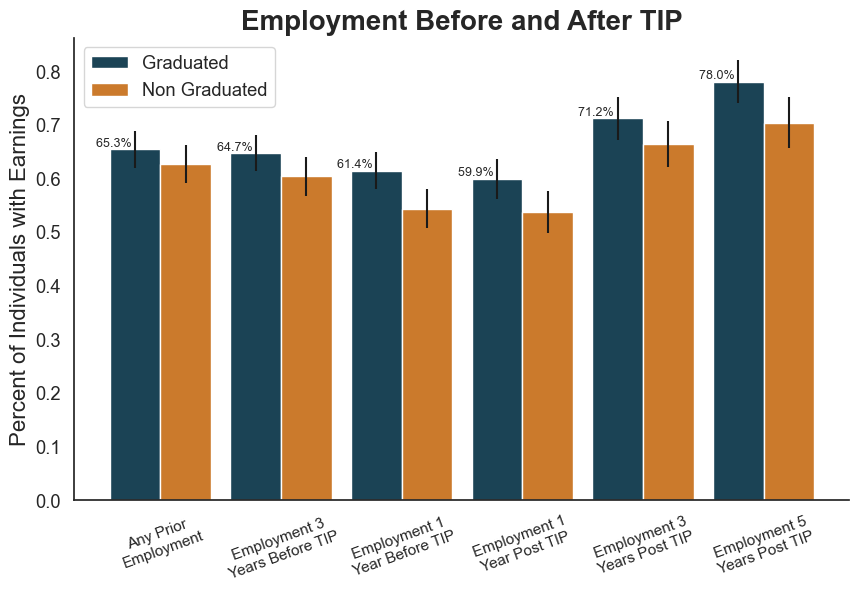

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nEmployment",
    "Employment 3\nYears Before TIP",
    "Employment 1\nYear Before TIP",
    "Employment 1\nYear Post TIP",
    "Employment 3\nYears Post TIP",
    "Employment 5\nYears Post TIP"
], rotation=20, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Employment Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Earnings', fontdict={'fontsize': 16})
plt.legend()
plt.show()

In [122]:
df.EndDate.max()

Timestamp('2025-03-03 00:00:00')

In [123]:
data_after.head(20)

,YearsSinceTIP,Graduated,Graduated Percent,Graduated Sample Size,Non Graduated,Non Graduated Percent,Non Graduated Sample Size,Interviewed,Interviewed Percent,Interviewed Sample Size,Graduated_Upper_CI,Graduated_Lower_CI,Non Graduated_Upper_CI,Non Graduated_Lower_CI,Interviewed_Upper_CI,Interviewed_Lower_CI
0,0.0,0,0.000000,759,0,0.000000,702,0,0.000000,550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.2,138,0.182781,755,99,0.142037,697,0,0.000000,512,0.210350,0.155213,0.167954,0.116121,0.000000,0.000000
2,0.4,235,0.319293,736,192,0.283186,678,1,0.002160,463,0.352975,0.285612,0.317100,0.249272,0.006389,-0.002069
3,0.6,312,0.443812,703,265,0.402736,658,1,0.002294,436,0.480540,0.407085,0.440210,0.365261,0.006784,-0.002197
4,0.8,380,0.556369,683,318,0.493023,645,1,0.002538,394,0.593629,0.519109,0.531607,0.454440,0.007506,-0.002430
5,1.0,399,0.599099,666,338,0.536508,630,1,0.002725,367,0.636320,0.561878,0.575448,0.497568,0.008058,-0.002609
6,1.2,411,0.628440,654,347,0.558776,621,1,0.002994,334,0.665475,0.591405,0.597830,0.519723,0.008853,-0.002865
7,1.4,402,0.640127,628,349,0.578773,603,1,0.003195,313,0.677666,0.602588,0.618183,0.539363,0.009447,-0.003057
8,1.6,407,0.661789,615,349,0.596581,585,1,0.003390,295,0.699180,0.624397,0.636336,0.556826,0.010023,-0.003243
9,1.8,400,0.675676,592,347,0.610915,568,1,0.003650,274,0.713385,0.637966,0.651011,0.570820,0.010790,-0.003491


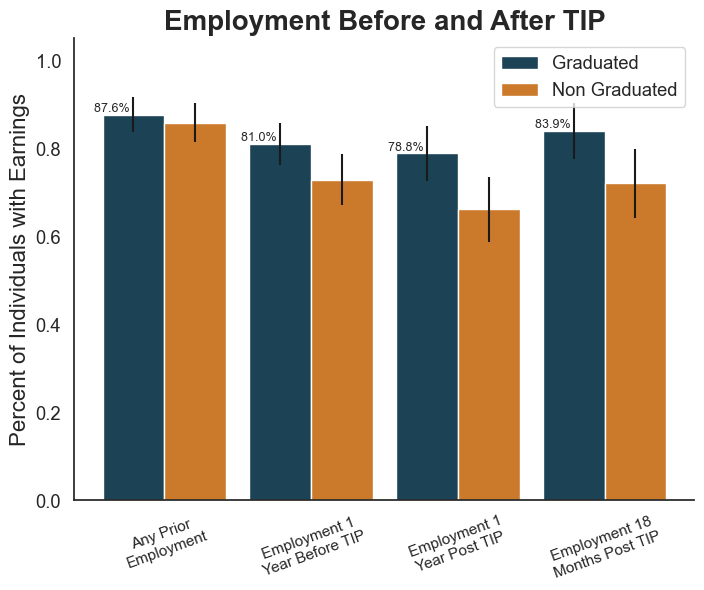

In [124]:
df_earnings_post_2022 = df_earnings[df_earnings['StartDate'] > '2022-01-01'].copy()
df_earnings_post_2022_year = df_earnings_post_2022.groupby(['tip_id', 'year']).agg({'earnings': 'sum'}).reset_index()

df_2022 = df[df['StartDate'] > '2022-01-01'].copy()

data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_earnings_post_2022[(df_earnings_post_2022['YearsSinceTIP'] >= i) & (df_earnings_post_2022['YearsSinceTIP'] < 0) & (df_earnings_post_2022['Status'] == 'Graduated')].copy()
    curr_non_grads = df_earnings_post_2022[(df_earnings_post_2022['YearsSinceTIP'] >= i) & (df_earnings_post_2022['YearsSinceTIP'] < 0) & (df_earnings_post_2022['Status'] == 'Non Graduated')].copy()
    curr_interviewed = df_earnings_post_2022[(df_earnings_post_2022['YearsSinceTIP'] >= i) & (df_earnings_post_2022['YearsSinceTIP'] < 0) & (df_earnings_post_2022['Status'] == 'Interviewed')].copy()
    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : curr_interviewed['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique()
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 10, (1/12)):
    curr_grads = df_earnings_post_2022[(df_earnings_post_2022['YearsSinceTIP'] >= 0) & (df_earnings_post_2022['YearsSinceTIP'] < i) & (df_earnings_post_2022['Status'] == 'Graduated') & (df_earnings_post_2022['ValidYears'] > i)].copy()
    curr_non_grads = df_earnings_post_2022[(df_earnings_post_2022['YearsSinceTIP'] >= 0) & (df_earnings_post_2022['YearsSinceTIP'] < i) & (df_earnings_post_2022['Status'] == 'Non Graduated') & (df_earnings_post_2022['ValidYears'] > i)].copy()
    curr_interviewed = df_earnings_post_2022[(df_earnings_post_2022['YearsSinceTIP'] >= 0) & (df_earnings_post_2022['YearsSinceTIP'] < i) & (df_earnings_post_2022['Status'] == 'Interviewed') & (df_earnings_post_2022['ValidYears'] > i)].copy()
    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : (curr_grads['tip_id'].nunique() / df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique()) if df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique() > 0 else 0,
        'Graduated Sample Size': df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : (curr_non_grads['tip_id'].nunique() / df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique()) if df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique() > 0 else 0,
        'Non Graduated Sample Size': df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : (curr_interviewed['tip_id'].nunique() / df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > i)].tip_id.nunique()) if df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > i)].tip_id.nunique() > 0 else 0,
        'Interviewed Sample Size': df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > i)].tip_id.nunique()
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Interviewed_Upper_CI'] = data_before['Interviewed Percent'] + 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique())
data_before['Interviewed_Lower_CI'] = data_before['Interviewed Percent'] - 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['Graduated Sample Size'])
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['Graduated Sample Size'])
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['Non Graduated Sample Size'])
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['Non Graduated Sample Size'])
data_after['Interviewed_Upper_CI'] = data_after['Interviewed Percent'] + 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['Interviewed Sample Size'])
data_after['Interviewed_Lower_CI'] = data_after['Interviewed Percent'] - 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['Interviewed Sample Size'])
data = pd.concat([
    data_before[(data_before['YearsSinceTIP'] == -30) | (data_before['YearsSinceTIP'] == -1)],
    data_after[(data_after['YearsSinceTIP'] == (12/12)) | (data_after['YearsSinceTIP'] == (18/12))]
])

data = data.drop(columns=['Interviewed', 'Interviewed Percent', 'Interviewed_Lower_CI', 'Interviewed_Upper_CI'])
data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Employment",
    "Employment 1 Year Before TIP",
    "Employment 1 Year Post TIP",
    "Employment 18 Months TIP"
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(8, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nEmployment",
    "Employment 1\nYear Before TIP",
    "Employment 1\nYear Post TIP",
    "Employment 18\nMonths Post TIP"
], rotation=20, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Employment Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Earnings', fontdict={'fontsize': 16})
plt.ylim(0, 1.05)
plt.legend()
plt.show()

In [125]:
pre_df_earnings = df_earnings[df_earnings['YearsSinceTIP'] < 0].copy()
post_df_earnings = df_earnings[df_earnings['YearsSinceTIP'] >= 0].copy()

In [126]:
pre_df_earnings.dropna(subset=['naics_sector_2022'], inplace=True)
post_df_earnings.dropna(subset=['naics_sector_2022'], inplace=True)


In [127]:
pre_df_earnings = pre_df_earnings.groupby(['tip_id']).agg(
    {
        'naics_sector_2022': 'max',
        'employer_legal_name': 'max',
        'Status': 'max'
    })

post_df_earnings = post_df_earnings.groupby(['tip_id']).agg(
    {
        'naics_sector_2022': 'max',
        'employer_legal_name': 'max',
        'Status': 'max'
    })

In [128]:
pre_df_earnings

,naics_sector_2022,employer_legal_name,Status
tip_id,,,
1,Health Care and Social Assistance,UPMC PRESBYTERIAN SHADYSIDE,Non Graduated
10,Administrative and Support and Waste Managemen...,PEOPLEREADY INC,Graduated
194,Other Services (except Public Administration),SKI MASONRY LLC,Non Graduated
256,Accommodation and Food Services,TOMS KING PENN LLC,Non Graduated
318,Construction,MILLENNIUM CONSTRUCTORS LLC,Graduated
...,...,...,...
2302,Wholesale Trade,V3 PIZZA,Non Graduated
2307,Transportation and Warehousing,WALTER'S BBQ SOUTHERN KITCHEN,Interviewed
2308,Transportation and Warehousing,VALVOLINE LLC,Interviewed


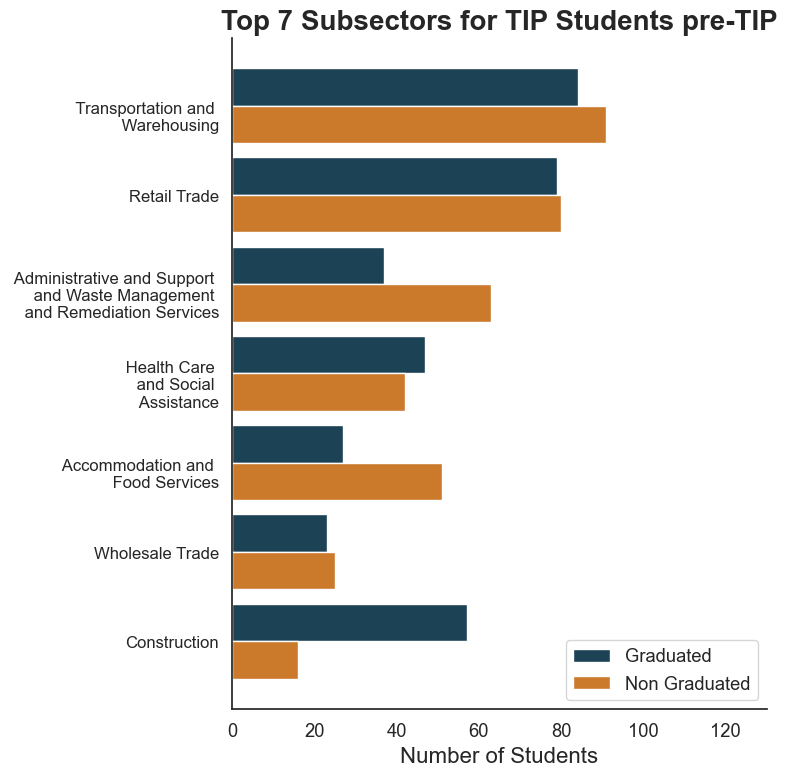

In [129]:
fig, ax = plt.subplots(figsize=(8, 8))

bar_height = 0.42
y_indexes = np.arange(7)

top_sectors = list(pre_df_earnings.naics_sector_2022.value_counts().head(7).keys())
graduated_top_sectors = pre_df_earnings[pre_df_earnings['Status'] == 'Graduated'].groupby('naics_sector_2022').size().reindex(top_sectors)
non_graduated_top_sectors = pre_df_earnings[pre_df_earnings['Status'] == 'Non Graduated'].groupby('naics_sector_2022').size().reindex(top_sectors)

# Wrap long sector names
new_top_sectors = []
for subsector in top_sectors:
    if len(subsector) > 60:
        subsector_length = subsector.split(' ')
        new_subsector = []
        for i in range(0, len(subsector_length)):
            if i % 3 == 0:
                new_subsector.append('\n')
            new_subsector.append(subsector_length[i])
        subsector = ' '.join(new_subsector)
    elif len(subsector) > 25:
        subsector_length = subsector.split(' ')
        new_subsector = []
        for i in range(0, len(subsector_length)):
            if i % 2 == 0:
                new_subsector.append('\n')
            new_subsector.append(subsector_length[i])
        subsector = ' '.join(new_subsector)
    new_top_sectors.append(subsector)

ax.barh(
    y_indexes - bar_height/2,
    graduated_top_sectors,
    height=bar_height,
    label='Graduated',
)

ax.barh(
    y_indexes + bar_height/2,
    non_graduated_top_sectors,
    height=bar_height,
    label='Non Graduated',
)

ax.set_yticks(y_indexes)
ax.set_yticklabels(new_top_sectors, fontsize=12)
ax.invert_yaxis()

sns.despine()

plt.title("Top 7 Subsectors for TIP Students pre-TIP", fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel("Number of Students", fontsize=16)
plt.ylabel("")
plt.xlim(0, 130)
plt.legend()
plt.tight_layout()
plt.show()


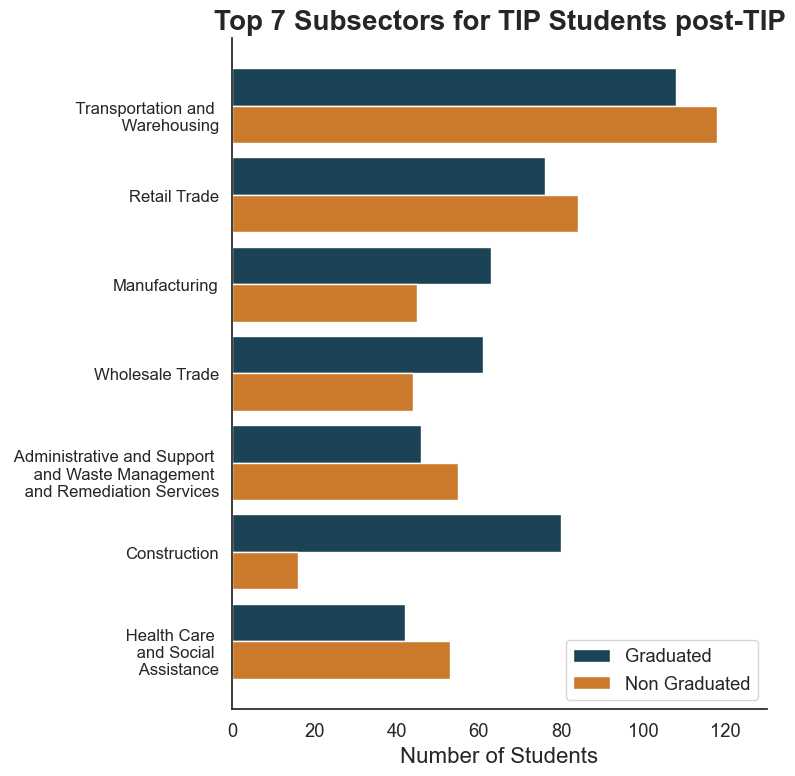

In [130]:
fig, ax = plt.subplots(figsize=(8, 8))

bar_height = 0.42
y_indexes = np.arange(7)

top_sectors = list(post_df_earnings.naics_sector_2022.value_counts().head(7).keys())
graduated_top_sectors = post_df_earnings[post_df_earnings['Status'] == 'Graduated'].groupby('naics_sector_2022').size().reindex(top_sectors)
non_graduated_top_sectors = post_df_earnings[post_df_earnings['Status'] == 'Non Graduated'].groupby('naics_sector_2022').size().reindex(top_sectors)

# Wrap long sector names
new_top_sectors = []
for subsector in top_sectors:
    if len(subsector) > 60:
        subsector_length = subsector.split(' ')
        new_subsector = []
        for i in range(0, len(subsector_length)):
            if i % 3 == 0:
                new_subsector.append('\n')
            new_subsector.append(subsector_length[i])
        subsector = ' '.join(new_subsector)
    elif len(subsector) > 25:
        subsector_length = subsector.split(' ')
        new_subsector = []
        for i in range(0, len(subsector_length)):
            if i % 2 == 0:
                new_subsector.append('\n')
            new_subsector.append(subsector_length[i])
        subsector = ' '.join(new_subsector)
    new_top_sectors.append(subsector)

# Plot horizontal bars
ax.barh(
    y_indexes - bar_height/2,
    graduated_top_sectors,
    height=bar_height,
    label='Graduated',
)

ax.barh(
    y_indexes + bar_height/2,
    non_graduated_top_sectors,
    height=bar_height,
    label='Non Graduated',
)

ax.set_yticks(y_indexes)
ax.set_yticklabels(new_top_sectors, fontsize=12)
ax.invert_yaxis()  # Largest bar at top

sns.despine()

plt.title("Top 7 Subsectors for TIP Students post-TIP", fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel("Number of Students", fontsize=16)
plt.ylabel("")
plt.xlim(0, 130)
plt.legend()
plt.tight_layout()
plt.show()


In [131]:
df_earnings

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,...,year_month,adjusted_earnings,Status,StartDate,InterviewedDate,EndDate,GraduatedDate,ValidYears,DOF,YearsSinceTIP
1,556,20174,COST COMPANY,3147,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,...,2017-04,4007.023666,Graduated,2017-05-08,NaT,2017-07-21,2017-07-21,7.616701,2017-04-01,-0.101303
2,556,20174,FRANCO,4654,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,...,2017-04,5925.862136,Graduated,2017-05-08,NaT,2017-07-21,2017-07-21,7.616701,2017-04-01,-0.101303
3,556,20181,COST COMPANY,1908,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,...,2018-01,2429.425216,Graduated,2017-05-08,NaT,2017-07-21,2017-07-21,7.616701,2018-01-01,0.449017
4,556,20181,FRANCO,7165,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,...,2018-01,9123.077396,Graduated,2017-05-08,NaT,2017-07-21,2017-07-21,7.616701,2018-01-01,0.449017
5,556,20181,GLUUTENY LLC,171,311811.0,Manufacturing,Food manufacturing,Retail Bakeries,Manufacturing,Food Manufacturing,...,2018-01,217.731505,Graduated,2017-05-08,NaT,2017-07-21,2017-07-21,7.616701,2018-01-01,0.449017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39481,1537,20243,PREMIUM PARKING OF BUFFALO LLC,1450,812930.0,Other services (except public administration),Personal and laundry services,Parking Lots and Garages,Other Services (except Public Administration),Personal and Laundry Services,...,2024-01,1846.261301,Non Graduated,2022-06-13,2022-05-31,2022-08-02,NaT,2.584531,2024-01-01,1.415498
39482,1833,20233,STEP BY STEP INC,15229,623210.0,Health care and social assistance,Nursing and residential care facilities,Residential Intellectual and Developmental Dis...,Health Care and Social Assistance,Nursing and Residential Care Facilities,...,2023-01,19390.836800,Interviewed,NaT,2023-07-25,NaT,NaT,1.607118,2023-01-01,-0.561271
39483,1833,20234,STEP BY STEP INC,19268,623210.0,Health care and social assistance,Nursing and residential care facilities,Residential Intellectual and Developmental Dis...,Health Care and Social Assistance,Nursing and Residential Care Facilities,...,2023-04,24533.629487,Interviewed,NaT,2023-07-25,NaT,NaT,1.607118,2023-04-01,-0.314859
39487,2297,20242,"WAL-MART ASSOCIATES, INC.",5255,455211.0,NaN,NaN,NaN,Retail Trade,General Merchandise Retailers,...,2024-01,6691.105613,Interviewed,NaT,2025-01-17,NaT,NaT,0.123203,2024-01-01,-1.045880


In [132]:
pre_tip_earnings = df_earnings[df_earnings['YearsSinceTIP'] < 0].copy()
pre_tip_earnings_grad = pre_tip_earnings[pre_tip_earnings['Status'] == 'Graduated'].groupby(['tip_id', 'year']).agg({'adjusted_earnings': 'sum'}).reset_index().groupby('tip_id').agg({'adjusted_earnings': 'mean'}).reset_index()
pre_tip_earnings_non_grad = pre_tip_earnings[pre_tip_earnings['Status'] == 'Non Graduated'].groupby(['tip_id', 'year']).agg({'adjusted_earnings': 'sum'}).reset_index().groupby('tip_id').agg({'adjusted_earnings': 'mean'}).reset_index()

post_tip_earnings = df_earnings[df_earnings['YearsSinceTIP'] >= 0].copy()
post_tip_earnings_grad = post_tip_earnings[post_tip_earnings['Status'] == 'Graduated'].groupby(['tip_id', 'year']).agg({'adjusted_earnings': 'sum'}).reset_index().groupby('tip_id').agg({'adjusted_earnings': 'mean'}).reset_index()
post_tip_earnings_non_grad = post_tip_earnings[post_tip_earnings['Status'] == 'Non Graduated'].groupby(['tip_id', 'year']).agg({'adjusted_earnings': 'sum'}).reset_index().groupby('tip_id').agg({'adjusted_earnings': 'mean'}).reset_index()

In [133]:
grad_comparison = pd.merge(
    pre_tip_earnings_grad,
    post_tip_earnings_grad,
    on='tip_id',
    how='inner',
    suffixes=('_pre', '_post')
)
grad_comparison['delta'] = grad_comparison['adjusted_earnings_post'] - grad_comparison['adjusted_earnings_pre']

non_grad_comparison = pd.merge(
    pre_tip_earnings_non_grad,
    post_tip_earnings_non_grad,
    on='tip_id',
    how='inner',
    suffixes=('_pre', '_post')
)
non_grad_comparison['delta'] = non_grad_comparison['adjusted_earnings_post'] - non_grad_comparison['adjusted_earnings_pre']

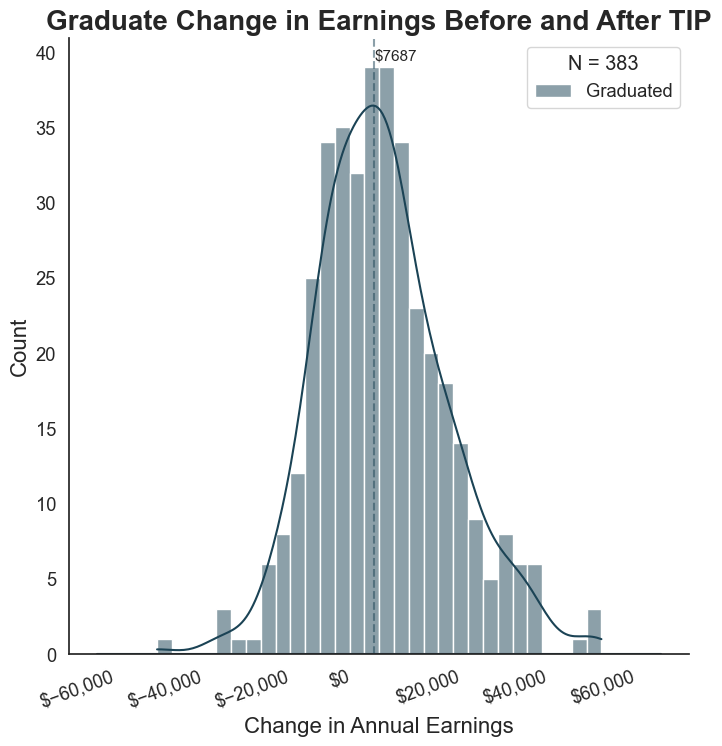

In [134]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    grad_comparison['delta'],
    kde=True,
    color=TIP_colors[0],
    label='Graduated',
    ax=ax,
    bins=30,
)

kde = sns.kdeplot(grad_comparison['delta'])
kde_peak = kde.get_lines()[0].get_data()
peak = kde_peak[1].argmax()
peak_value = kde_peak[0][peak]
ax.axvline(peak_value, color=TIP_colors[0], linestyle='--', alpha=0.5)
ax.text(peak_value + 5000, 39.3, f'${peak_value:.0f}', ha='center', va='bottom', fontsize=11, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Graduate Change in Earnings Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
label = f"N = {grad_comparison.shape[0]}"

ax.xaxis.set_major_formatter('${x:,.0f}')
plt.xticks(rotation=20) 
plt.xlabel('Change in Annual Earnings', fontdict={'fontsize': 16})
plt.ylabel('Count', fontdict={'fontsize': 16})
plt.legend(title=label)
plt.show()


In [135]:
grad_comparison.describe()

,tip_id,adjusted_earnings_pre,adjusted_earnings_post,delta
count,383.000000,383.000000,383.000000,383.000000
mean,1149.263708,12127.930850,21885.854207,9757.923357
std,425.211707,10360.260956,16451.134597,14922.180200
min,10.000000,166.800159,16.552688,-41790.442879
25%,780.000000,5045.227327,9444.581520,-387.523881
50%,1146.000000,9308.340168,18717.779059,8568.107620
75%,1524.500000,16207.468499,31977.245741,18535.190183
max,1877.000000,68255.007030,97748.076357,59714.032478


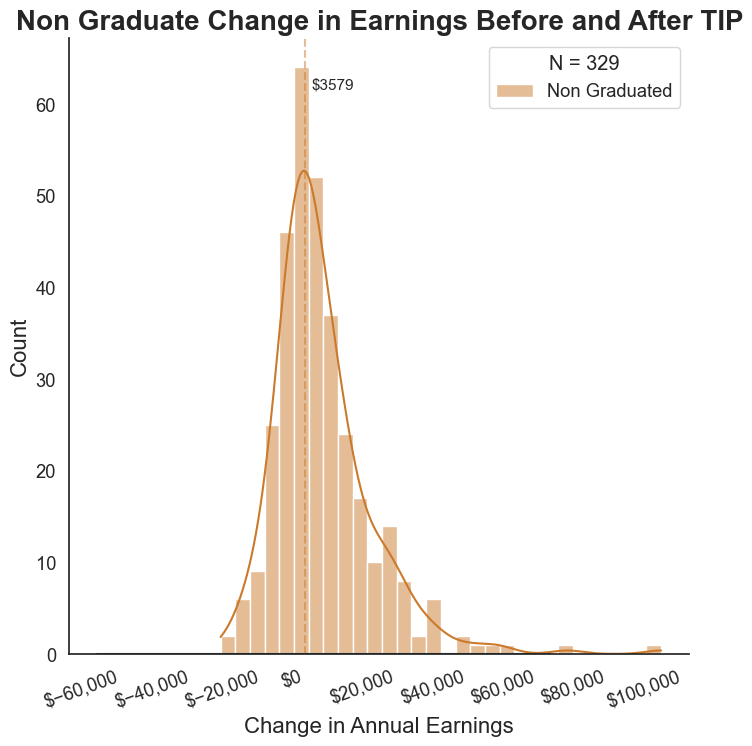

In [136]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    non_grad_comparison['delta'],
    kde=True,
    color=TIP_colors[1],
    label='Non Graduated',
    ax=ax,
    bins=30,
)

kde = sns.kdeplot(grad_comparison['delta'])
kde_peak = kde.get_lines()[0].get_data()
peak = kde_peak[1].argmax()
peak_value = kde_peak[0][peak]
ax.axvline(peak_value, color=TIP_colors[1], linestyle='--', alpha=0.5)
ax.text(peak_value + 8000, 61.3, f'${peak_value:.0f}', ha='center', va='bottom', fontsize=11, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Non Graduate Change in Earnings Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
label = f"N = {non_grad_comparison.shape[0]}"

ax.xaxis.set_major_formatter('${x:,.0f}')
plt.xticks(rotation=20) 
plt.xlabel('Change in Annual Earnings', fontdict={'fontsize': 16})
plt.ylabel('Count', fontdict={'fontsize': 16})
plt.legend(title=label)
plt.show()


In [137]:
non_grad_comparison.describe()

,tip_id,adjusted_earnings_pre,adjusted_earnings_post,delta
count,329.000000,329.000000,329.000000,329.000000
mean,1190.686930,8580.340219,17218.466821,8638.126601
std,413.130637,10122.748957,18056.814700,14268.343144
min,1.000000,87.856572,17.825971,-20360.824289
25%,849.000000,2489.906190,4827.018340,335.764900
50%,1215.000000,5726.593244,12518.500479,5617.218177
75%,1531.000000,10293.861718,23894.186435,13725.148958
max,1926.000000,91173.900627,169534.917593,105009.825262


In [138]:
pre_tip_earnings = df_earnings_post_2022[df_earnings_post_2022['YearsSinceTIP'] < 0].copy()
pre_tip_earnings_grad = pre_tip_earnings[pre_tip_earnings['Status'] == 'Graduated'].groupby(['tip_id', 'year']).agg({'adjusted_earnings': 'sum'}).reset_index().groupby('tip_id').agg({'adjusted_earnings': 'mean'}).reset_index()
pre_tip_earnings_non_grad = pre_tip_earnings[pre_tip_earnings['Status'] == 'Non Graduated'].groupby(['tip_id', 'year']).agg({'adjusted_earnings': 'sum'}).reset_index().groupby('tip_id').agg({'adjusted_earnings': 'mean'}).reset_index()

post_tip_earnings = df_earnings_post_2022[df_earnings_post_2022['YearsSinceTIP'] >= 0].copy()
post_tip_earnings_grad = post_tip_earnings[post_tip_earnings['Status'] == 'Graduated'].groupby(['tip_id', 'year']).agg({'adjusted_earnings': 'sum'}).reset_index().groupby('tip_id').agg({'adjusted_earnings': 'mean'}).reset_index()
post_tip_earnings_non_grad = post_tip_earnings[post_tip_earnings['Status'] == 'Non Graduated'].groupby(['tip_id', 'year']).agg({'adjusted_earnings': 'sum'}).reset_index().groupby('tip_id').agg({'adjusted_earnings': 'mean'}).reset_index()

grad_comparison = pd.merge(
    pre_tip_earnings_grad,
    post_tip_earnings_grad,
    on='tip_id',
    how='inner',
    suffixes=('_pre', '_post')
)
grad_comparison['delta'] = grad_comparison['adjusted_earnings_post'] - grad_comparison['adjusted_earnings_pre']

non_grad_comparison = pd.merge(
    pre_tip_earnings_non_grad,
    post_tip_earnings_non_grad,
    on='tip_id',
    how='inner',
    suffixes=('_pre', '_post')
)
non_grad_comparison['delta'] = non_grad_comparison['adjusted_earnings_post'] - non_grad_comparison['adjusted_earnings_pre']

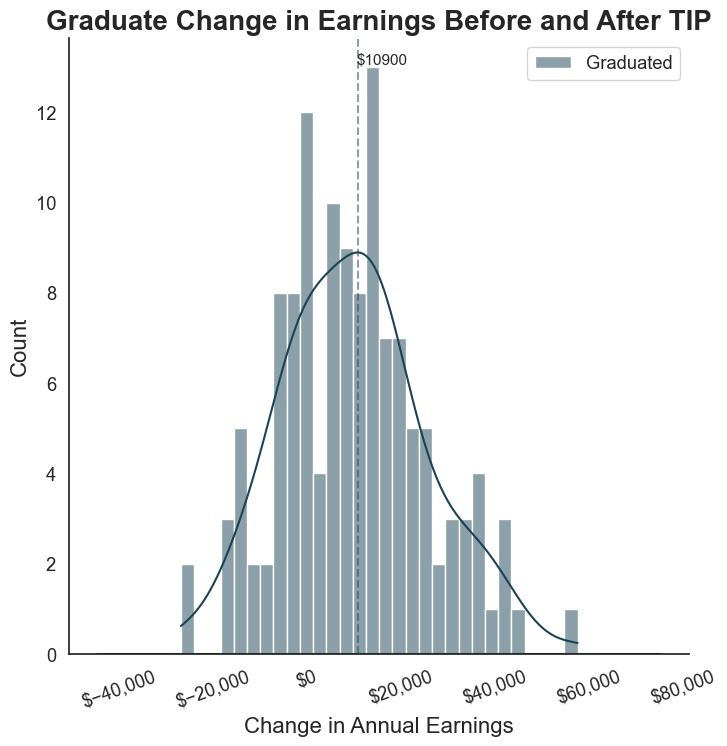

In [139]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    grad_comparison['delta'],
    kde=True,
    color=TIP_colors[0],
    label='Graduated',
    ax=ax,
    bins=30,
)

kde = sns.kdeplot(grad_comparison['delta'])
kde_peak = kde.get_lines()[0].get_data()
peak = kde_peak[1].argmax()
peak_value = kde_peak[0][peak]
ax.axvline(peak_value, color=TIP_colors[0], linestyle='--', alpha=0.5)
ax.text(peak_value + 5000, 13, f'${peak_value:.0f}', ha='center', va='bottom', fontsize=11, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Graduate Change in Earnings Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
ax.xaxis.set_major_formatter('${x:,.0f}')
plt.xticks(rotation=20) 
plt.xlabel('Change in Annual Earnings', fontdict={'fontsize': 16})
plt.ylabel('Count', fontdict={'fontsize': 16})
plt.legend()
plt.show()


In [140]:
pre_df_earnings = df_earnings_post_2022[df_earnings_post_2022['YearsSinceTIP'] < 0].copy()
post_df_earnings = df_earnings_post_2022[df_earnings_post_2022['YearsSinceTIP'] >= 0].copy()

pre_df_earnings.dropna(subset=['naics_sector_2022'], inplace=True)
post_df_earnings.dropna(subset=['naics_sector_2022'], inplace=True)

pre_df_earnings = pre_df_earnings.groupby(['tip_id']).agg(
    {
        'naics_sector_2022': 'max',
        'employer_legal_name': 'max',
        'Status': 'max'
    })

post_df_earnings = post_df_earnings.groupby(['tip_id']).agg(
    {
        'naics_sector_2022': 'max',
        'employer_legal_name': 'max',
        'Status': 'max'
    })

total_earnings_path = pd.merge(
    pre_df_earnings,
    post_df_earnings,
    on='tip_id',
    how='inner',
    suffixes=('_pre', '_post')
)

total_earnings_path.reset_index(inplace=True)

total_earnings_path['Path'] = total_earnings_path['naics_sector_2022_pre'] + ' -> ' + total_earnings_path['naics_sector_2022_post']
paths = total_earnings_path[total_earnings_path['Status_pre'] == 'Graduated']
paths[paths['naics_sector_2022_pre'] != paths['naics_sector_2022_post']].groupby('Path').size().sort_values(ascending=False).head(5) / paths.shape[0]

Path
Retail Trade -> Health Care and Social Assistance                                           0.039062
Transportation and Warehousing -> Construction                                              0.031250
Transportation and Warehousing -> Retail Trade                                              0.031250
Retail Trade -> Administrative and Support and Waste Management and Remediation Services    0.031250
Retail Trade -> Transportation and Warehousing                                              0.031250
dtype: float64

In [141]:
total_earnings_path['Path'] = total_earnings_path['naics_sector_2022_pre'] + ' -> ' + total_earnings_path['naics_sector_2022_post']
paths = total_earnings_path[total_earnings_path['Status_pre'] == 'Graduated']
paths[paths['naics_sector_2022_post'] == 'Construction'].groupby('Path').size().sort_values(ascending=False).head(7) / paths.shape[0]

Path
Construction -> Construction                                                                0.031250
Retail Trade -> Construction                                                                0.031250
Transportation and Warehousing -> Construction                                              0.031250
Administrative and Support and Waste Management and Remediation Services -> Construction    0.023438
Manufacturing -> Construction                                                               0.015625
Wholesale Trade -> Construction                                                             0.015625
Mining, Quarrying, and Oil and Gas Extraction -> Construction                               0.007812
dtype: float64

In [142]:
paths[paths['naics_sector_2022_post'] == 'Construction'].groupby('employer_legal_name_post').size().sort_values(ascending=False)

employer_legal_name_post
WYATT INCORPORATED                     3
THE MASSARO CORPORATION                2
MOSITES CONSTRUCTION CO                2
HARRIS MASONRY INC                     1
PRIMANTI CORPORATION                   1
WALLER URBAN ENTERPRISES INC           1
SMG                                    1
REFTECH INTERNATIONAL CORP             1
PROFESSIONAL HAND D MAN CONTRACTING    1
PLIBRICO COMPANY LLC                   1
JT THORPE & SON INC                    1
NORALCO CORPORATION                    1
MICHAEL FACCHIANO CONTRACTING INC      1
MARSA INC                              1
KUSLER MASONRY INC.                    1
KOPER MASONRY INC                      1
KARUS LLC                              1
ZEUS CONSTRUCTION CO                   1
dtype: int64

In [143]:
total_earnings_path['Path'] = total_earnings_path['naics_sector_2022_pre'] + ' -> ' + total_earnings_path['naics_sector_2022_post']
paths = total_earnings_path[total_earnings_path['Status_pre'] == 'Non Graduated']
paths[paths['naics_sector_2022_pre'] != paths['naics_sector_2022_post']].groupby('Path').size().sort_values(ascending=False).head(5) / paths.shape[0]

Path
Retail Trade -> Transportation and Warehousing                                                                0.075472
Transportation and Warehousing -> Health Care and Social Assistance                                           0.066038
Transportation and Warehousing -> Administrative and Support and Waste Management and Remediation Services    0.066038
Retail Trade -> Accommodation and Food Services                                                               0.056604
Retail Trade -> Health Care and Social Assistance                                                             0.047170
dtype: float64

In [144]:
paths.groupby('Path').size().sort_values(ascending=False).head(15) / paths.shape[0]

Path
Transportation and Warehousing -> Transportation and Warehousing                                                                                        0.113208
Retail Trade -> Transportation and Warehousing                                                                                                          0.075472
Retail Trade -> Retail Trade                                                                                                                            0.075472
Transportation and Warehousing -> Administrative and Support and Waste Management and Remediation Services                                              0.066038
Transportation and Warehousing -> Health Care and Social Assistance                                                                                     0.066038
Retail Trade -> Accommodation and Food Services                                                                                                         0.056604
Retail Trade -> Health Care a

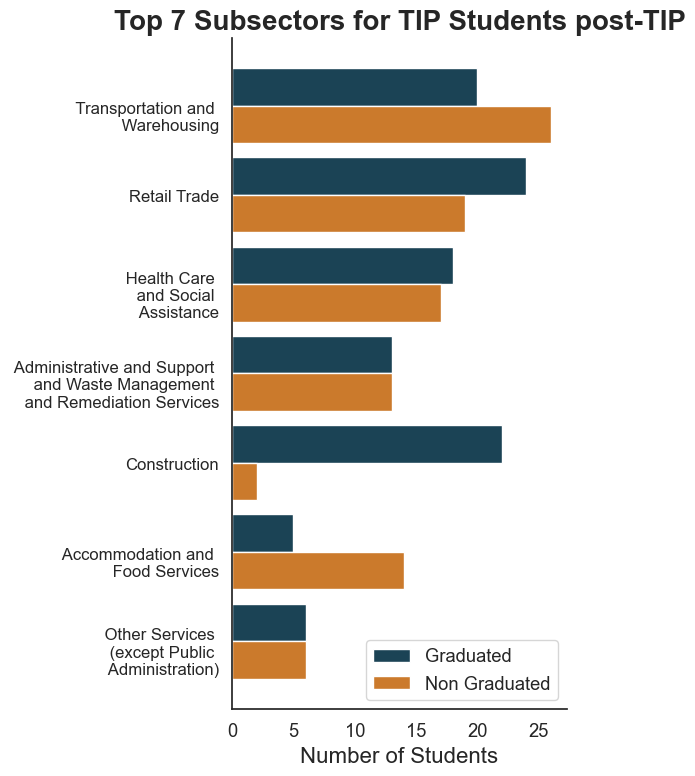

In [145]:
fig, ax = plt.subplots(figsize=(6, 8))

bar_height = 0.42
y_indexes = np.arange(7)

top_sectors = list(post_df_earnings.naics_sector_2022.value_counts().head(7).keys())
graduated_top_sectors = post_df_earnings[post_df_earnings['Status'] == 'Graduated'].groupby('naics_sector_2022').size().reindex(top_sectors)
non_graduated_top_sectors = post_df_earnings[post_df_earnings['Status'] == 'Non Graduated'].groupby('naics_sector_2022').size().reindex(top_sectors)

# Wrap long sector names
new_top_sectors = []
for subsector in top_sectors:
    if len(subsector) > 60:
        subsector_length = subsector.split(' ')
        new_subsector = []
        for i in range(0, len(subsector_length)):
            if i % 3 == 0:
                new_subsector.append('\n')
            new_subsector.append(subsector_length[i])
        subsector = ' '.join(new_subsector)
    elif len(subsector) > 25:
        subsector_length = subsector.split(' ')
        new_subsector = []
        for i in range(0, len(subsector_length)):
            if i % 2 == 0:
                new_subsector.append('\n')
            new_subsector.append(subsector_length[i])
        subsector = ' '.join(new_subsector)
    new_top_sectors.append(subsector)

# Plot horizontal bars
ax.barh(
    y_indexes - bar_height/2,
    graduated_top_sectors,
    height=bar_height,
    label='Graduated',
)

ax.barh(
    y_indexes + bar_height/2,
    non_graduated_top_sectors,
    height=bar_height,
    label='Non Graduated',
)

ax.set_yticks(y_indexes)
ax.set_yticklabels(new_top_sectors, fontsize=12)
ax.invert_yaxis()  # Largest bar at top

sns.despine()

plt.title("Top 7 Subsectors for TIP Students post-TIP", fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel("Number of Students", fontsize=16)
plt.ylabel("")
plt.xlim(0, )
plt.legend()
plt.tight_layout()
plt.show()

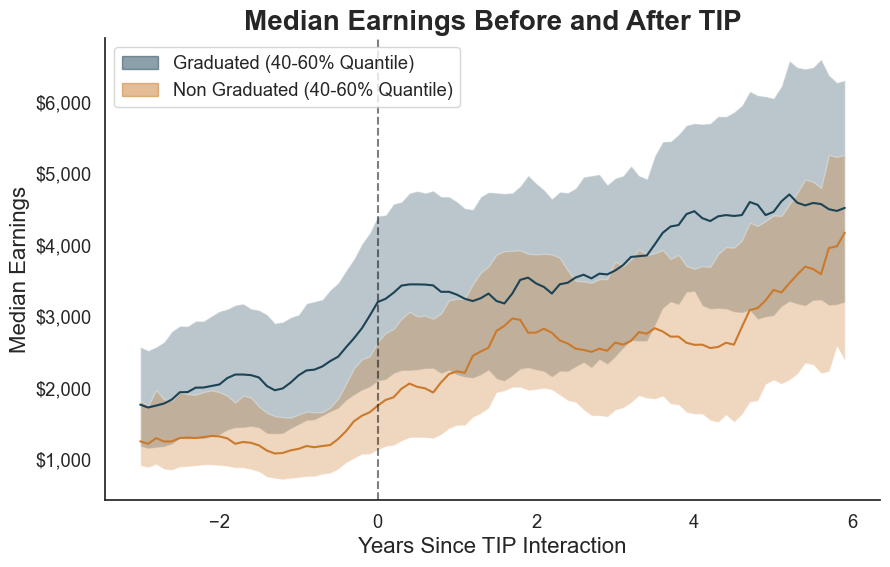

In [146]:
data = []
for i in np.arange(-3, 6, 0.1):
    i = float(round(i, 1))
    curr_grads = df_earnings[(df_earnings['YearsSinceTIP'] >= i) & (df_earnings['YearsSinceTIP'] < i + 1) & (df_earnings['Status'] == 'Graduated')].copy()
    curr_non_grads = df_earnings[(df_earnings['YearsSinceTIP'] >= i) & (df_earnings['YearsSinceTIP'] < i + 1) & (df_earnings['Status'] == 'Non Graduated')].copy()

    data.append({
        'YearsSinceTIP': i,
        'GraduateMedianSalary': curr_grads['earnings'].median(),
        'GraduateUpperPercentile': curr_grads['earnings'].quantile(0.6),
        'GraduateLowerPercentile': curr_grads['earnings'].quantile(0.4),
        'NonGraduateMedianSalary': curr_non_grads['earnings'].median(),
        'NonGraduateUpperPercentile': curr_non_grads['earnings'].quantile(0.6),
        'NonGraduateLowerPercentile': curr_non_grads['earnings'].quantile(0.4),
    })

data = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=data,
    x='YearsSinceTIP',
    y='GraduateMedianSalary',
    label='Graduated'
)

plt.fill_between(
    data['YearsSinceTIP'],
    data['GraduateLowerPercentile'],
    data['GraduateUpperPercentile'],
    alpha=0.3
)

sns.lineplot(
    data=data,
    x='YearsSinceTIP',
    y='NonGraduateMedianSalary',
    label='Non Graduated'
)

plt.fill_between(
    data['YearsSinceTIP'],
    data['NonGraduateLowerPercentile'],
    data['NonGraduateUpperPercentile'],
    alpha=0.3
)

plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

sns.despine()

ax.yaxis.set_major_formatter('${x:,.0f}')
plt.title('Median Earnings Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Years Since TIP Interaction', fontdict={'fontsize': 16})
plt.ylabel('Median Earnings', fontdict={'fontsize': 16})
grad_patch = matplotlib.patches.Patch(color=TIP_colors[0], alpha=0.5, label='Graduated (40-60% Quantile)')
non_grad_patch = matplotlib.patches.Patch(color=TIP_colors[1], alpha=0.5, label='Non Graduated (40-60% Quantile)')

plt.legend(handles=[grad_patch, non_grad_patch], loc='upper left')
plt.show()


In [147]:
data[data['YearsSinceTIP'] < 0].mean()

YearsSinceTIP                   -1.550000
GraduateMedianSalary          2150.500000
GraduateUpperPercentile       3109.340000
GraduateLowerPercentile       1456.266667
NonGraduateMedianSalary       1267.533333
NonGraduateUpperPercentile    1855.880000
NonGraduateLowerPercentile     867.300000
dtype: float64

In [148]:
df_services = pd.read_csv('tip_cohort_human_services_activity.csv')
df_services = pd.merge(
    df_services,
    df[['tip_id', 'Status', 'StartDate', 'InterviewedDate', 'EndDate', 'GraduatedDate']],
    on='tip_id',
    how='left'
)

df_services['DOF'] = pd.to_datetime(df_services['year'], format='%Y')
df_services['YearsSinceTIP'] = df_services.apply(years_since_TIP, axis=1)

In [149]:
df_services.replace(0, np.nan, inplace=True)

In [150]:
df_services.tip_id.nunique()

2166

In [151]:
df_services.groupby('tip_id').any().reset_index().sum().sort_values(ascending=False) / df['tip_id'].nunique()

C:\Users\13429\AppData\Local\Temp\ipykernel_28980\534327278.py:1: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  df_services.groupby('tip_id').any().reset_index().sum().sort_values(ascending=False) / df['tip_id'].nunique()


tip_id                   1242.923956
Unnamed: 0                  1.076541
year                        1.076541
DOF                         1.076541
GraduatedDate               1.076541
EndDate                     1.076541
InterviewedDate             1.076541
StartDate                   1.076541
medicaid                    1.005467
courts                      0.978131
Status                      0.937376
YearsSinceTIP               0.934394
snap                        0.896620
mental_health               0.660537
cyf_referral                0.655567
jail                        0.647614
drug_alcohol                0.485089
jail_collab                 0.390656
matp                        0.293241
section8_housing            0.261431
dhs_housing_supports        0.227137
cyf_parent                  0.209245
cyf_child                   0.164513
link_referral               0.159543
tanf                        0.118290
ssi                         0.113817
public_housing              0.093936
i

In [152]:
df_services_subset = df_services[['tip_id', 'year', 'YearsSinceTIP', 'Status','snap']].copy()

In [153]:
df_services.dropna(subset=['aging', 'drug_alcohol', 'mental_health', 'cyf_child',
       'cyf_parent', 'family_support_center', 'early_childhood', 'jail_collab',
       'matp', 'home_visiting', 'dhs_housing_supports', 'indep_living',
       'intellectual_disab', 'cyf_referral', 'link_referral', 'public_housing',
       'section8_housing', 'courts', 'medicaid', 'jail', 'snap', 'tanf', 'ssi',
       'ccdf'], inplace=True, how='all')

df_services_subset.dropna(subset=['snap'], inplace=True, how='all')

In [154]:
df_services_subset

,tip_id,year,YearsSinceTIP,Status,snap
19,302,2020,NaN,NaN,1.0
20,302,2021,NaN,NaN,1.0
21,302,2022,NaN,NaN,1.0
22,302,2023,NaN,NaN,1.0
23,302,2024,NaN,NaN,1.0
...,...,...,...,...,...
27477,1066,2022,1.946652,Non Graduated,1.0
27478,1066,2023,2.945988,Non Graduated,1.0
27479,1066,2024,3.945324,Non Graduated,1.0
27486,2187,2017,-7.726374,Graduated,1.0


In [155]:
curr_grads

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,...,year_month,adjusted_earnings,Status,StartDate,InterviewedDate,EndDate,GraduatedDate,ValidYears,DOF,YearsSinceTIP
100,122,20183,EMPLOYER SOLUTIONS STAFFING GRP II,86,561320.0,Administrative and support and waste managemen...,Administrative and support services,Temporary Help Services,Administrative and Support and Waste Managemen...,Administrative and Support Services,...,2018-01,109.502394,Graduated,2011-01-06,NaT,2011-03-25,2011-03-25,13.941136,2018-01-01,6.773582
101,122,20183,OS RESTAURANT SERVICES LLC,139,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,...,2018-01,176.986428,Graduated,2011-01-06,NaT,2011-03-25,2011-03-25,13.941136,2018-01-01,6.773582
163,88,20183,ARG RESOURCES LLC,1222,722513.0,Accommodation and food services,Food services and drinking places,Limited-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,...,2018-01,1555.952628,Graduated,2011-01-31,NaT,2011-03-25,2011-03-25,13.941136,2018-01-01,6.773582
192,122,20182,OS RESTAURANT SERVICES LLC,2707,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,...,2018-01,3446.778857,Graduated,2011-01-06,NaT,2011-03-25,2011-03-25,13.941136,2018-01-01,6.773582
411,40,20174,KUSLER MASONRY INC.,7938,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,...,2017-04,10107.325663,Graduated,2010-08-02,NaT,2010-11-05,2010-11-05,14.324435,2017-04-01,6.403964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39450,585,20241,MCDONALDS,3599,722513.0,Accommodation and food services,Food services and drinking places,Limited-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,...,2024-01,4582.547878,Graduated,2017-07-17,NaT,2017-08-31,2017-08-31,7.504449,2024-01-01,6.335517
39451,585,20242,CHAMPION CARRIER CORPORATION,19289,336211.0,Manufacturing,Transportation equipment manufacturing,Motor Vehicle Body Manufacturing,Manufacturing,Transportation Equipment Manufacturing,...,2024-01,24560.368444,Graduated,2017-07-17,NaT,2017-08-31,2017-08-31,7.504449,2024-01-01,6.335517
39452,585,20242,MCDONALDS,3319,722513.0,Accommodation and food services,Food services and drinking places,Limited-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,...,2024-01,4226.028455,Graduated,2017-07-17,NaT,2017-08-31,2017-08-31,7.504449,2024-01-01,6.335517
39453,585,20243,CHAMPION CARRIER CORPORATION,4922,336211.0,Manufacturing,Transportation equipment manufacturing,Motor Vehicle Body Manufacturing,Manufacturing,Transportation Equipment Manufacturing,...,2024-01,6267.102156,Graduated,2017-07-17,NaT,2017-08-31,2017-08-31,7.504449,2024-01-01,6.335517


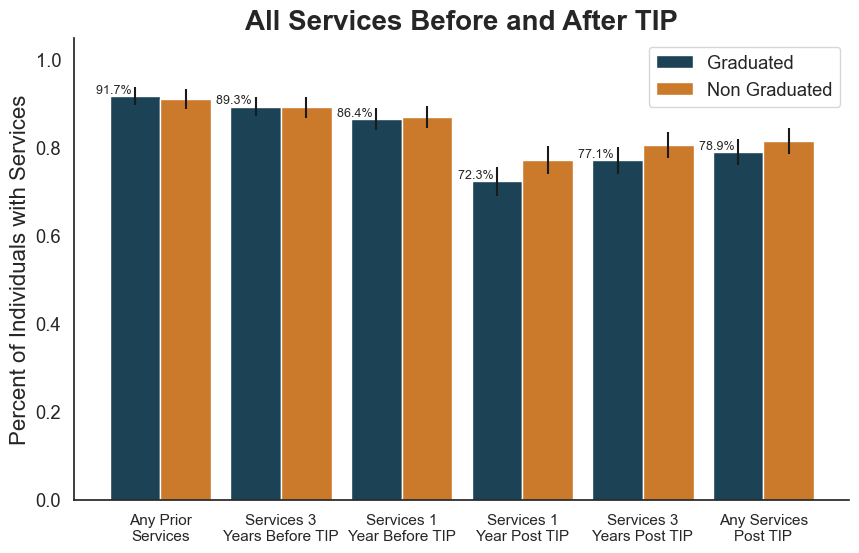

In [156]:
data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_services[(df_services['YearsSinceTIP'] >= i) & (df_services['YearsSinceTIP'] < 0) & (df_services['Status'] == 'Graduated')].copy()
    curr_non_grads = df_services[(df_services['YearsSinceTIP'] >= i) & (df_services['YearsSinceTIP'] < 0) & (df_services['Status'] == 'Non Graduated')].copy()

    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df[df['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df[df['Status'] == 'Non Graduated'].tip_id.nunique(),
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 30.2, 0.2):
    curr_grads = df_services[(df_services['YearsSinceTIP'] >= 0) & (df_services['YearsSinceTIP'] < i) & (df_services['Status'] == 'Graduated')].copy()
    curr_non_grads = df_services[(df_services['YearsSinceTIP'] >= 0) & (df_services['YearsSinceTIP'] < i) & (df_services['Status'] == 'Non Graduated')].copy()

    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df[df['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df[df['Status'] == 'Non Graduated'].tip_id.nunique(),
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_services[df_services['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_services[df_services['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_services[df_services['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_services[df_services['Status'] == 'Non Graduated'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / df_services[df_services['Status'] == 'Graduated'].tip_id.nunique())
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / df_services[df_services['Status'] == 'Graduated'].tip_id.nunique())
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / df_services[df_services['Status'] == 'Non Graduated'].tip_id.nunique())
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / df_services[df_services['Status'] == 'Non Graduated'].tip_id.nunique())

a = data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)]
b = data_after[(data_after['YearsSinceTIP'] == 1) | (data_after['YearsSinceTIP'] == 3) | (data_after['YearsSinceTIP'] == 30)]

data = pd.concat([a, b])

data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Services",
    "Services 3 Years Before TIP",
    "Services 1 Year Before TIP",
    "Services 1 Year Post TIP",
    "Services 3 Years Post TIP",
    "Any Services Post TIP"
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nServices",
    "Services 3\nYears Before TIP",
    "Services 1\nYear Before TIP",
    "Services 1\nYear Post TIP",
    "Services 3\nYears Post TIP",
    "Any Services\nPost TIP"
], rotation=0, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('All Services Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Services', fontdict={'fontsize': 16})
plt.ylim(0, 1.05)
plt.legend()
plt.show()

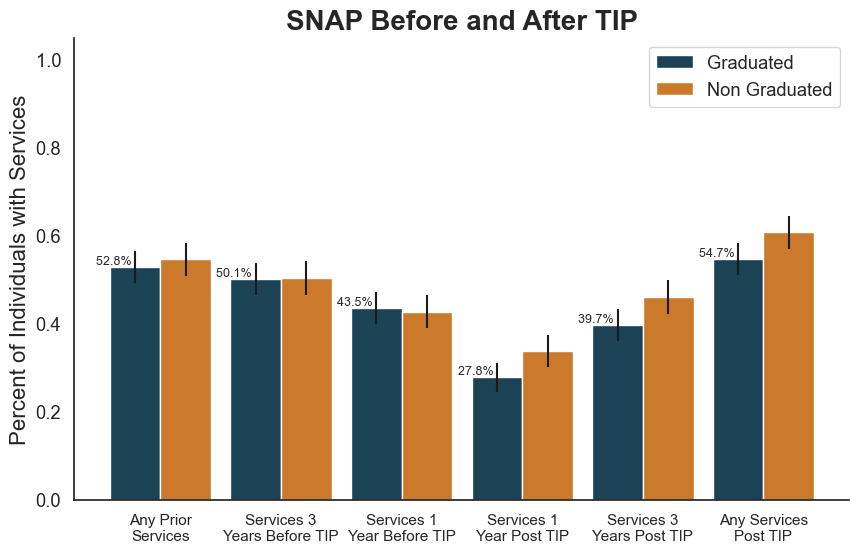

In [157]:
data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_services_subset[(df_services_subset['YearsSinceTIP'] >= i) & (df_services_subset['YearsSinceTIP'] < 0) & (df_services_subset['Status'] == 'Graduated')].copy()
    curr_non_grads = df_services_subset[(df_services_subset['YearsSinceTIP'] >= i) & (df_services_subset['YearsSinceTIP'] < 0) & (df_services_subset['Status'] == 'Non Graduated')].copy()

    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df[df['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df[df['Status'] == 'Non Graduated'].tip_id.nunique(),
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 30.2, 0.2):
    curr_grads = df_services_subset[(df_services_subset['YearsSinceTIP'] >= 0) & (df_services_subset['YearsSinceTIP'] < i) & (df_services_subset['Status'] == 'Graduated')].copy()
    curr_non_grads = df_services_subset[(df_services_subset['YearsSinceTIP'] >= 0) & (df_services_subset['YearsSinceTIP'] < i) & (df_services_subset['Status'] == 'Non Graduated')].copy()

    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df[df['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df[df['Status'] == 'Non Graduated'].tip_id.nunique(),
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_services[df_services['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_services[df_services['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_services[df_services['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_services[df_services['Status'] == 'Non Graduated'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / df_services[df_services['Status'] == 'Graduated'].tip_id.nunique())
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / df_services[df_services['Status'] == 'Graduated'].tip_id.nunique())
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / df_services[df_services['Status'] == 'Non Graduated'].tip_id.nunique())
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / df_services[df_services['Status'] == 'Non Graduated'].tip_id.nunique())

a = data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)]
b = data_after[(data_after['YearsSinceTIP'] == 1) | (data_after['YearsSinceTIP'] == 3) | (data_after['YearsSinceTIP'] == 30)]

data = pd.concat([a, b])

data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Services",
    "Services 3 Years Before TIP",
    "Services 1 Year Before TIP",
    "Services 1 Year Post TIP",
    "Services 3 Years Post TIP",
    "Any Services Post TIP"
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nServices",
    "Services 3\nYears Before TIP",
    "Services 1\nYear Before TIP",
    "Services 1\nYear Post TIP",
    "Services 3\nYears Post TIP",
    "Any Services\nPost TIP"
], rotation=0, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

# for i, (x, y, upper, lower) in enumerate(zip(x_indexes + width/2, data['Non Graduated Percent'], data['Non Graduated_Upper_CI'], data['Non Graduated_Lower_CI'])):
#     ax.text(x, y, f" {y:.1%}", ha='left', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('SNAP Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Services', fontdict={'fontsize': 16})
plt.ylim(0, 1.05)
plt.legend()
plt.show()

In [158]:
df_services

,Unnamed: 0,tip_id,year,aging,drug_alcohol,mental_health,cyf_child,cyf_parent,family_support_center,early_childhood,...,tanf,ssi,ccdf,Status,StartDate,InterviewedDate,EndDate,GraduatedDate,DOF,YearsSinceTIP
0,1,632,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2011-01-01,-6.770844
1,2,632,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2012-01-01,-5.771508
2,3,632,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2013-01-01,-4.769434
3,4,632,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2014-01-01,-3.770098
4,5,632,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2015-01-01,-2.770762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27488,27489,2187,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Graduated,2024-09-23,2024-09-05,2024-12-06,2024-12-06,2019-01-01,-5.727701
27489,27490,2187,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Graduated,2024-09-23,2024-09-05,2024-12-06,2024-12-06,2020-01-01,-4.728365
27490,27491,2187,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Graduated,2024-09-23,2024-09-05,2024-12-06,2024-12-06,2021-01-01,-3.726291
27491,27492,2187,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Graduated,2024-09-23,2024-09-05,2024-12-06,2024-12-06,2022-01-01,-2.726955


In [159]:
df_services.describe()

,Unnamed: 0,tip_id,year,aging,drug_alcohol,mental_health,cyf_child,cyf_parent,family_support_center,early_childhood,...,snap,tanf,ssi,ccdf,StartDate,InterviewedDate,EndDate,GraduatedDate,DOF,YearsSinceTIP
count,27493.000000,27493.000000,27493.000000,17.0,2545.0,5670.0,987.0,1393.0,358.0,0.0,...,8328.0,594.0,1458.0,104.0,18070,15649,17547,8898,27493,23165.000000
mean,13747.000000,1150.747718,2017.259993,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,2019-09-09 22:36:57.775318528,2022-08-14 20:13:32.524762112,2019-09-19 17:23:32.549153792,2019-10-04 22:40:32.366823936,2017-04-05 13:29:10.307351040,-3.404578
min,1.000000,1.000000,2010.000000,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,2009-01-12 00:00:00,2019-03-28 00:00:00,2009-01-15 00:00:00,2009-03-23 00:00:00,2010-01-01 00:00:00,-15.080392
25%,6874.000000,592.000000,2014.000000,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,2017-02-13 00:00:00,2021-04-27 00:00:00,2017-03-02 00:00:00,2017-02-11 18:00:00,2014-01-01 00:00:00,-7.490914
50%,13747.000000,1142.000000,2017.000000,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,2019-10-28 00:00:00,2022-10-25 00:00:00,2019-11-01 00:00:00,2019-09-09 00:00:00,2017-01-01 00:00:00,-3.419646
75%,20620.000000,1713.000000,2021.000000,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,2022-11-07 00:00:00,2024-02-01 00:00:00,2022-11-04 00:00:00,2023-01-20 00:00:00,2021-01-01 00:00:00,0.098565
max,27493.000000,2310.000000,2024.000000,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,2025-01-27 00:00:00,2025-01-30 00:00:00,2025-03-03 00:00:00,2025-01-23 00:00:00,2024-01-01 00:00:00,14.959924
std,7936.689812,655.057784,4.272958,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,5.511144
